# Analyzing price ratio

In [651]:
import pandas as pd
from importlib import reload
import numpy as np
import datetime
import math
import sys

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import matplotlib.dates as dates

import common
reload(common)
import moving
reload(moving)
import render
reload(render)

<module 'render' from '/Users/fedor/PROJECTS/Stock/tools/notebook/render.py'>

## Loading stocks prices history from './history' folder

In [580]:
history = common.load_history('./history')
stocks = pd.read_csv('data/stocks.tcs', index_col=0)

513 files with prices hoistory found
513 files with prices hoistory loaded
99096 items totaly since 2000-02-29 00:00:00 to 2018-07-13 00:00:00


## Ignore symbols younger than 2016

In [581]:
ignored = common.younger_than(history)
history = common.older_than(history)
print('{} symbols ignored: {}'.format(len(ignored), ignored.keys()))

17 symbols ignored: dict_keys(['AA', 'BGIO', 'BHF', 'BHGE', 'CBH', 'DHCP', 'DLPH', 'DWDP', 'DXC', 'FTV', 'HGV', 'MFGP', 'MOSC', 'UA', 'VNE-WI', 'WELL', 'WLTW'])


## Extract periods and append columns 'price-ratio', 'max-prev', 'price-drop', 'drop-period', 'price-growth'

Here each symbol history divided in few periods to study them separately and to compare them.
Periods are:
    - all history
    - middle 50% of hostry
    - first 25% of histry
    - first 50% of histry
    - first 75% of histry    
    - last 75% of hostry
    - last 50% of hostry
    - last 25% of hostry
    - last N years of history (symbols younger N years excluded) where N in [2, 3, 5, 7, 10, 15]

In [588]:
def before_now(years):
    return pd.datetime.now() - pd.Timedelta('{} days'.format(365 * years))

periods = [('first-25', (0.,0.25)), ('first-50', (0.,0.5)), ('first-75', (0.,0.75)), ('all', (0.,1.)),
           ('middle-50', (0.25,0.75)), ('last-75', (0.25,1.)), ('last-50', (0.5,1.)), ('last-25', (0.75,1.))]
now = pd.datetime.now()
abs_periods = [('last-15y', (before_now(15), now)), ('last-10y', (before_now(10), now)), 
               ('last-7y', (before_now(7), now)), ('last-5y', (before_now(5), now)),
               ('last-3y', (before_now(3), now)), ('last-2y', (before_now(2), now))]

In [589]:
hist_per = {}
for (p_name, period) in periods:
    hp = common.prepare_history_period(history, period[0], period[1])
    hist_per[p_name] = hp
    
for (p_name, period) in abs_periods:
    hp = common.prepare_history_abs_period(history, period[0], period[1])
    hist_per[p_name] = hp

### Append column with price ratio to symbol history.

Price ratio value for current date is a ratio of current close price to first open price in symbol history

### Append columns with max price ratio for previous periods

Max price ratio value for current date is a maximum price ratio since begin of symbol history to current date inclusivle 

### Append column with price drop after last maximum

Price drop value for current date is ratio of current price ratio to current max price ratio. It shows depth of price fall since last price maximum.

### Append column with price drop period in days

Price drop period  for current date is number of days passed since last price maximum.

### Append column with average price growth ratio for last 1, 2, 3, 4 and 5 years

Average price growth ratio value for current date is ratio of current close price to open price at begin of time window averaged for specified period

In [598]:
for (p_name, hp) in hist_per.items():
    common.append_price_ratio_column(hp)
    common.append_max_prev_column(hp)
    common.append_price_drop_column(hp)
    common.append_drop_period_column(hp)
    common.append_price_grouth_column(hp, windows = range(1,6))
    print('Period "{}" - OK'.format(p_name))

Period "first-25" - OK
Period "first-50" - OK
Period "first-75" - OK
Period "all" - OK
Period "middle-50" - OK
Period "last-75" - OK
Period "last-50" - OK
Period "last-25" - OK
Period "last-15y" - OK
Period "last-10y" - OK
Period "last-7y" - OK
Period "last-5y" - OK
Period "last-3y" - OK
Period "last-2y" - OK


## Draw price ratio

Function **draw_price_ratio** draws two curves on one chart for target symbol:
    - black color curve shows price ratio for all hisory
    - red color curve show price ratio for target period
    - tiny black horizontal line show value 1 - first open price ratio in history
    - tiny red vertical lines show target period in all history period
    - light green and red strips show drop periods
    
Also it shows average price growth ratio per year for target period and for last year. One can see it in char title.

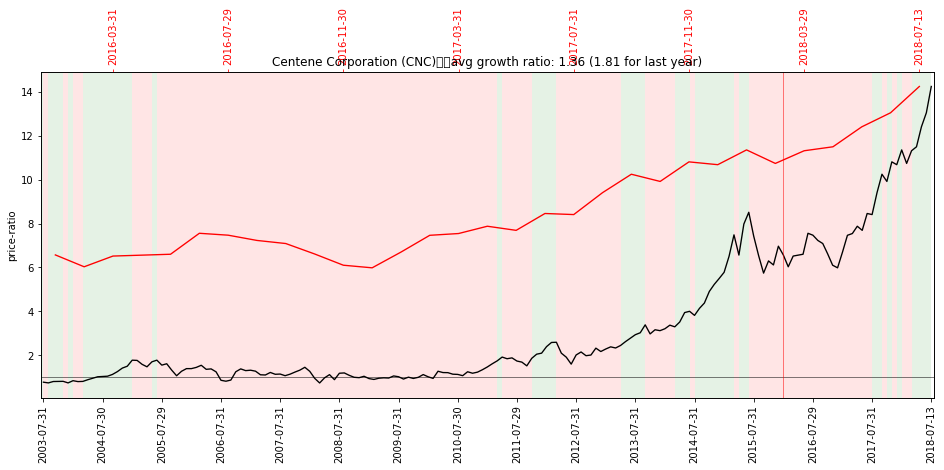

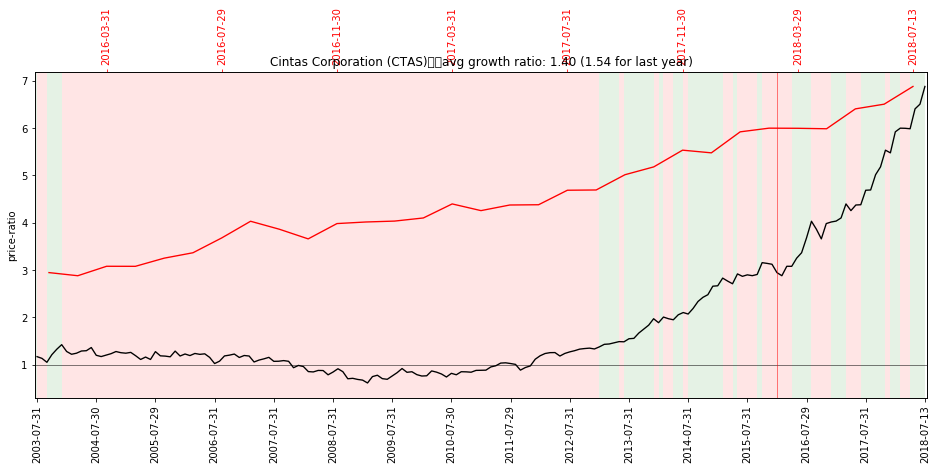

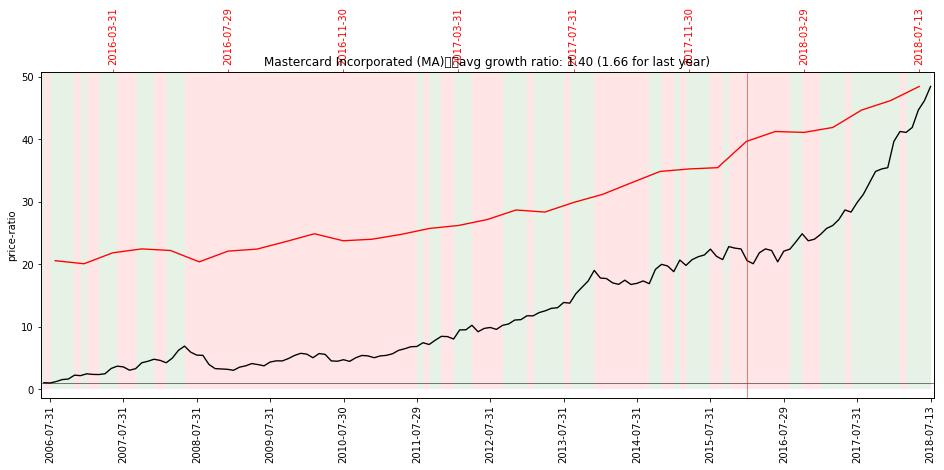

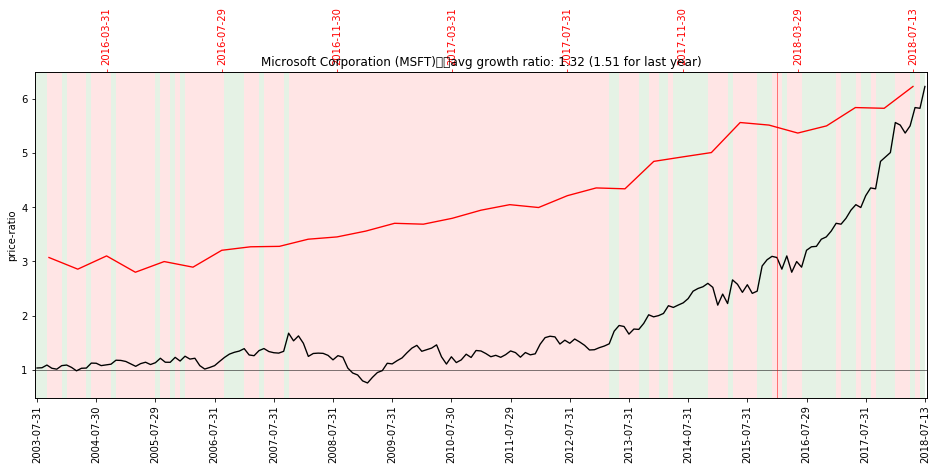

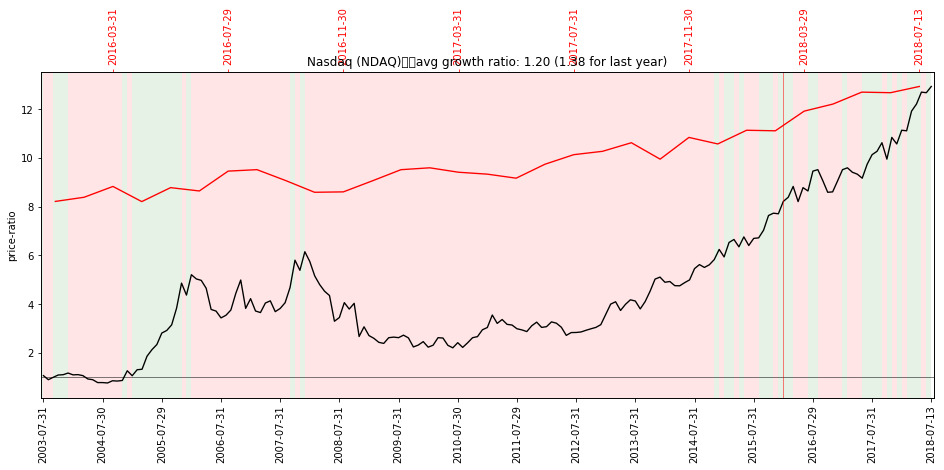

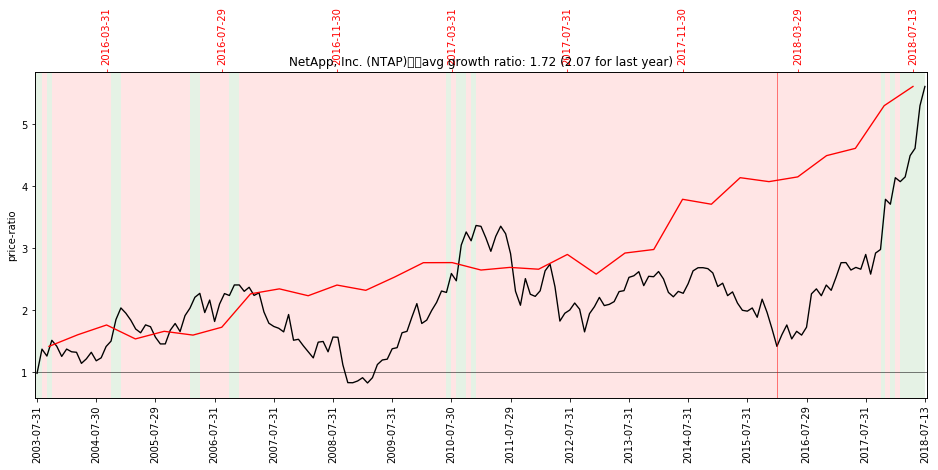

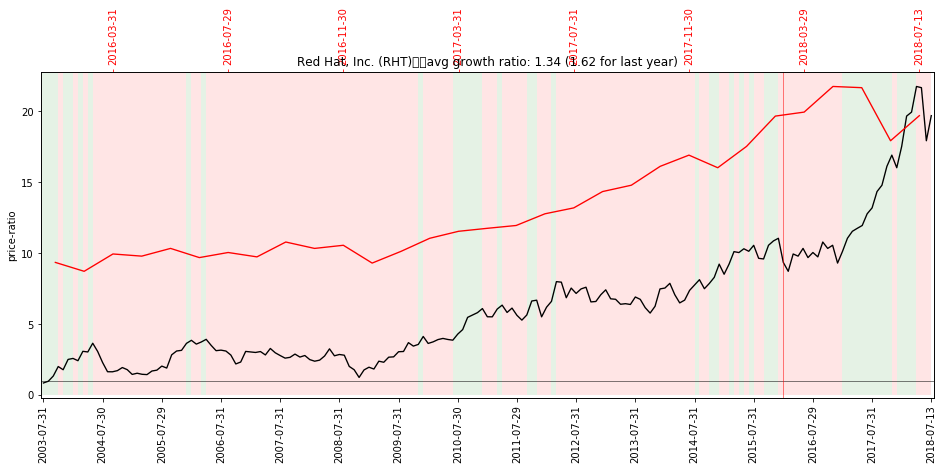

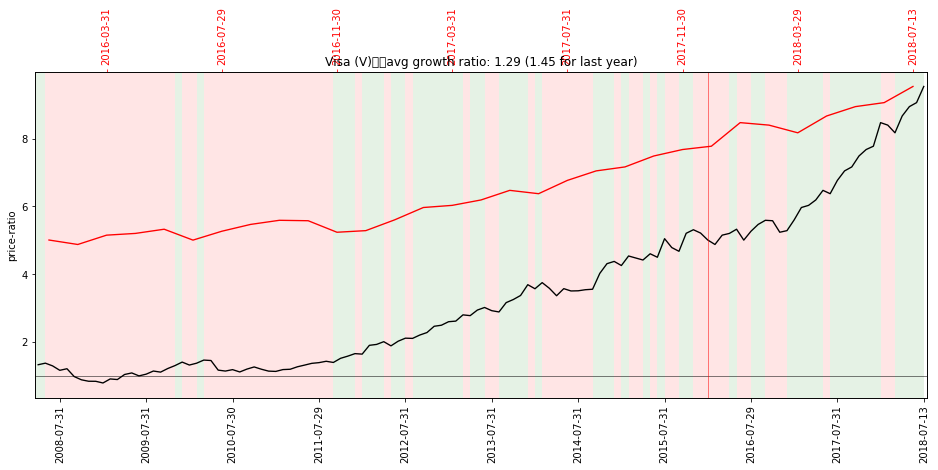

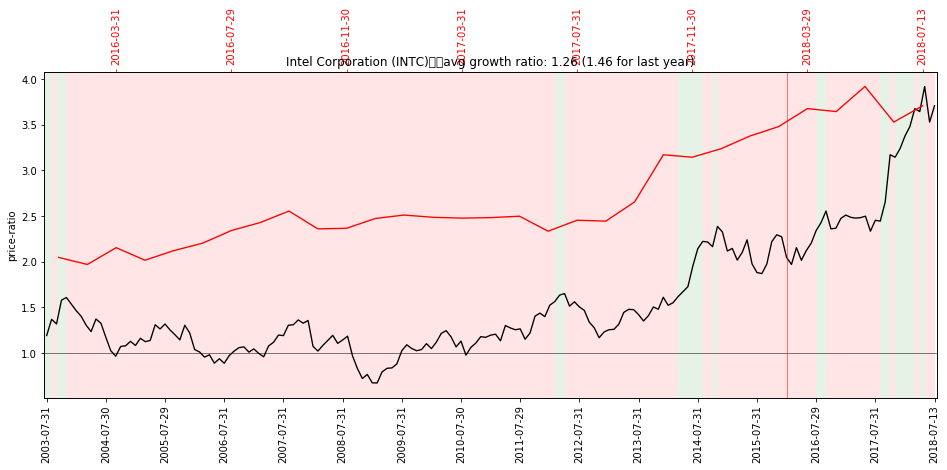

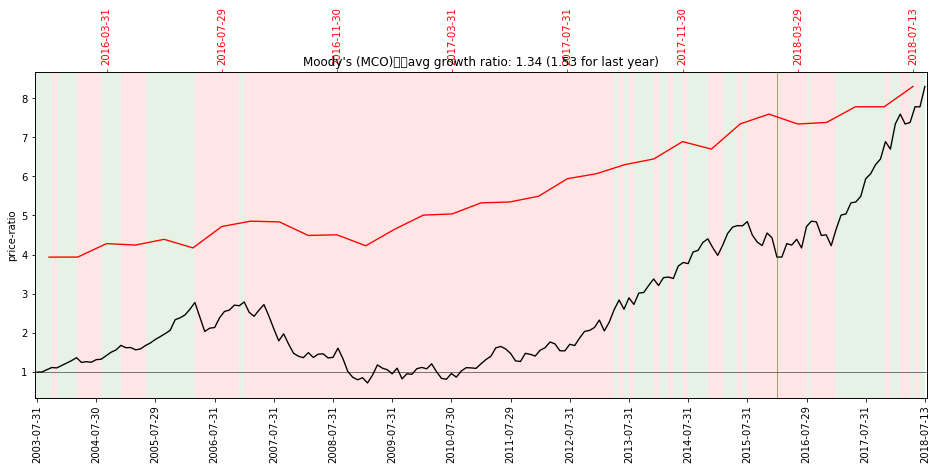

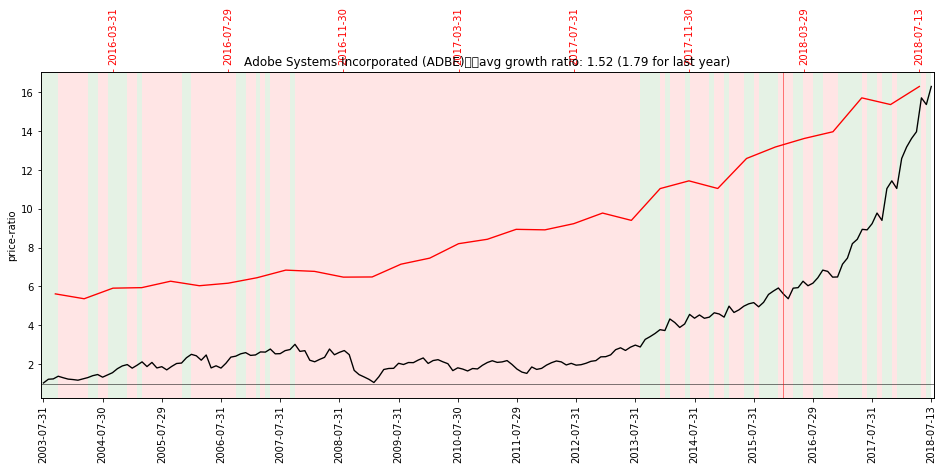

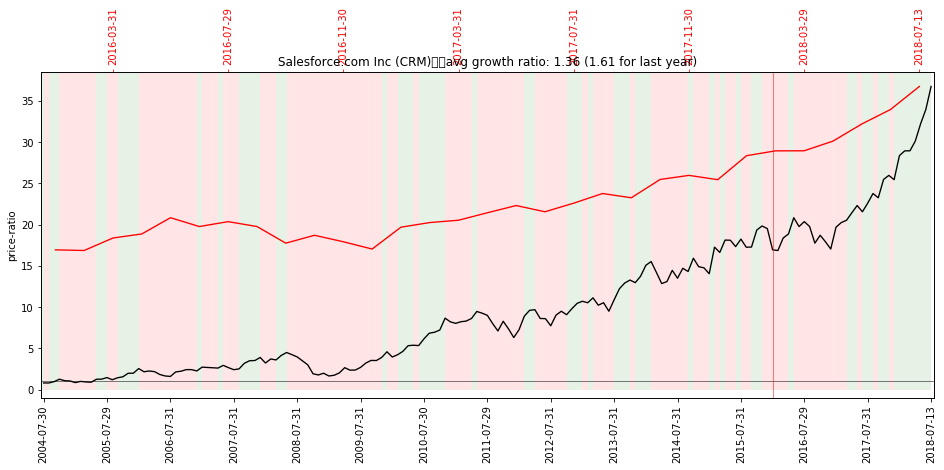

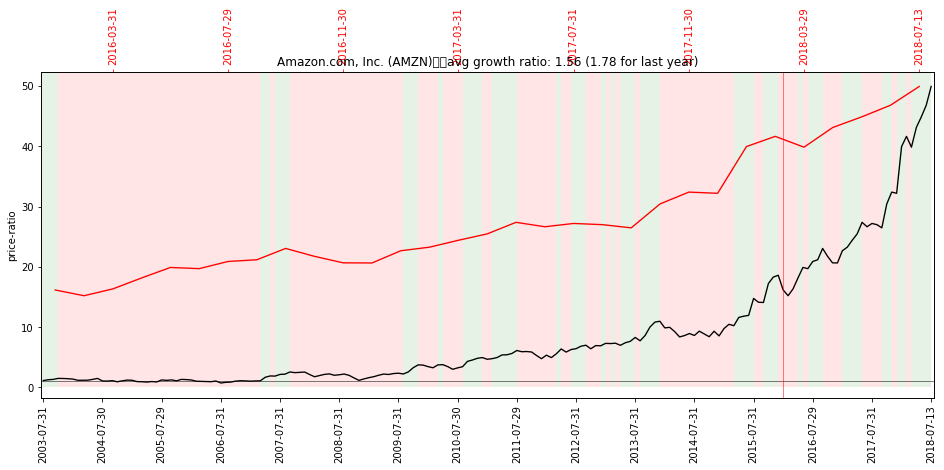

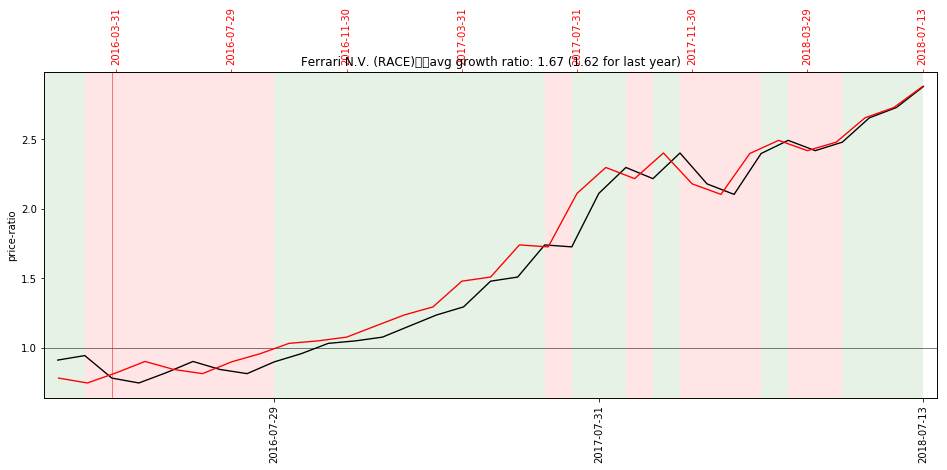

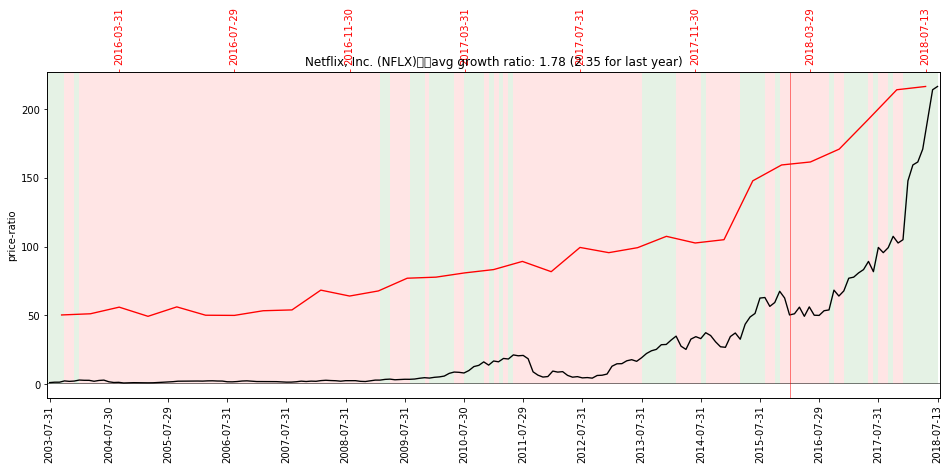

In [633]:
for symbol in ['CNC', 'CTAS', 'MA', 'MSFT', 'NDAQ', 'NTAP', 'RHT', 'V', 'INTC', 'MCO', 'ADBE', 'CRM', 'AMZN', 'RACE', 'NFLX']:
    if symbol in hist_per['last-15y']:
        hp = hist_per['last-15y']
    else:
        hp = hist_per['all']
    render.draw_column(hp, symbol, stocks['Name'][symbol], period = ('2016', '2100'), add = ['drop-periods'])

## Look at top-30 of symbols with fastest price growth in last year

In [639]:
hp = hist_per['all']
price_ratio_growth_speed_top = sorted([(h['price-growth-1y'][-1], symbol) for (symbol, h) in hp.items()], reverse = True)

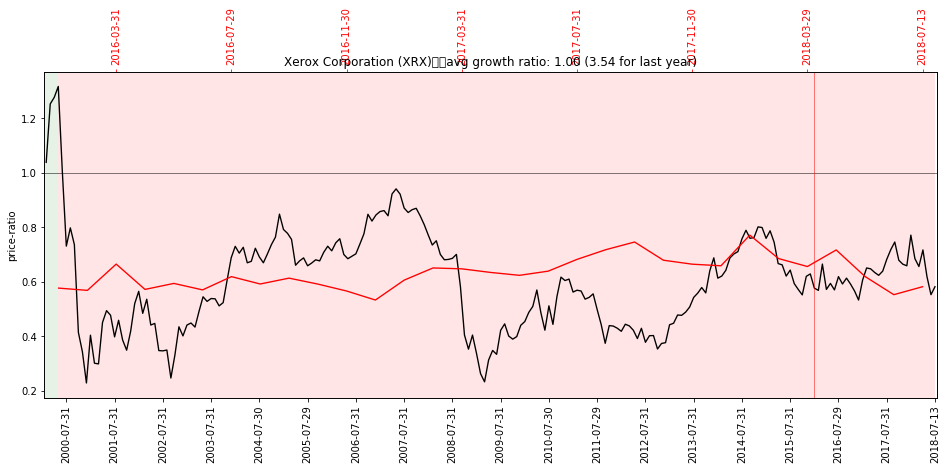

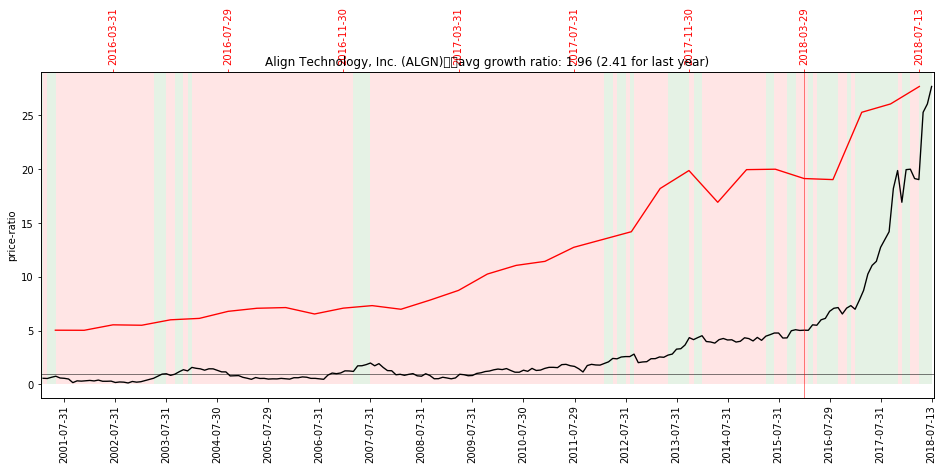

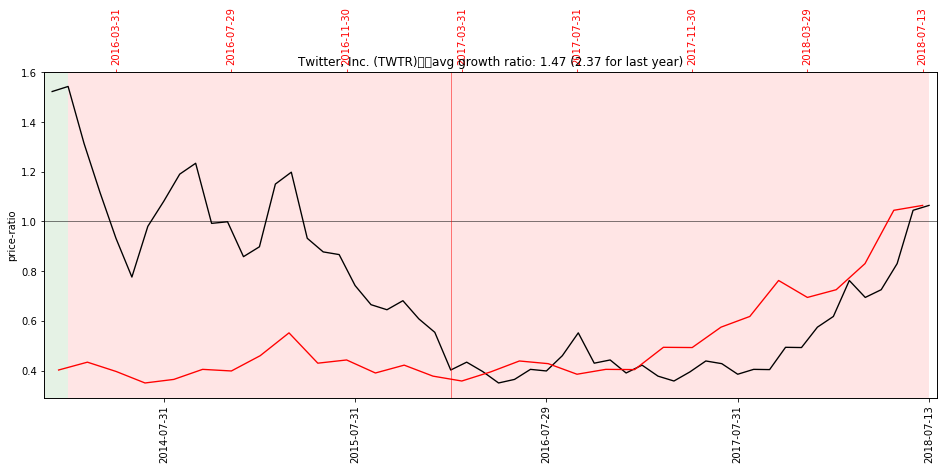

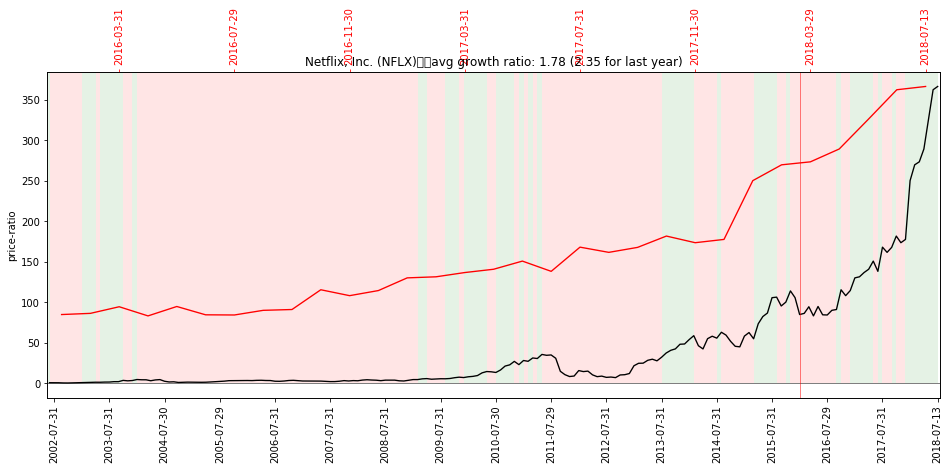

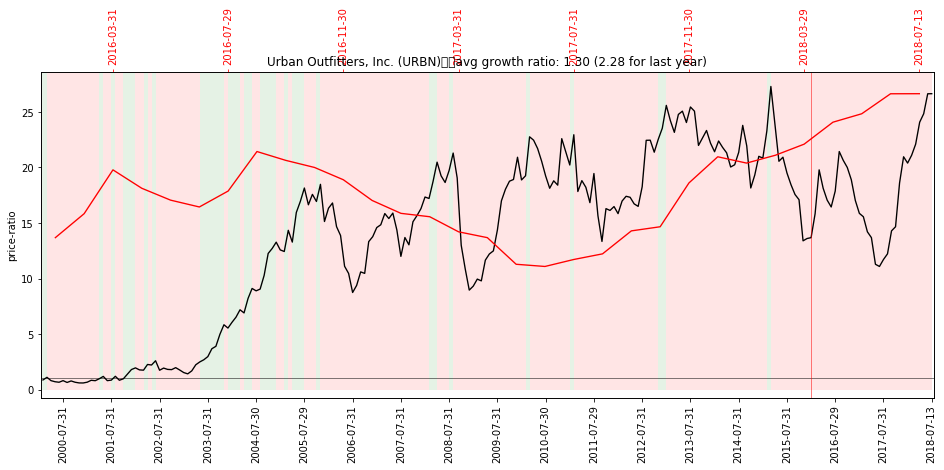

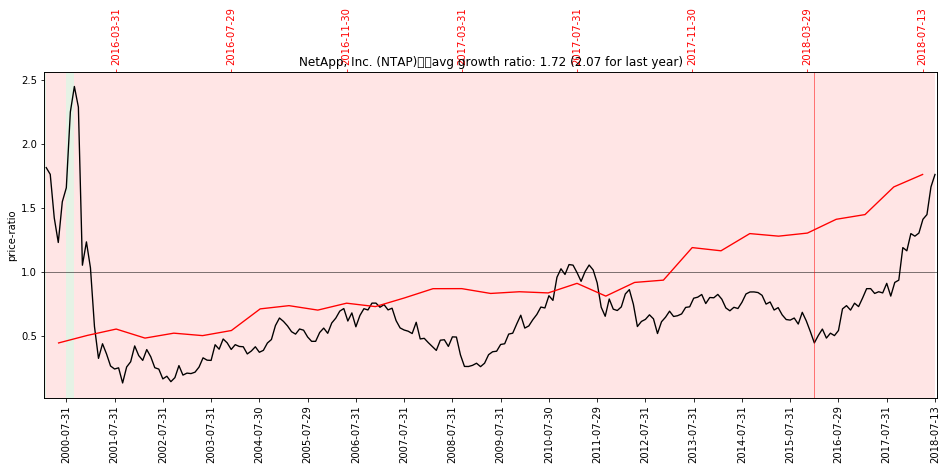

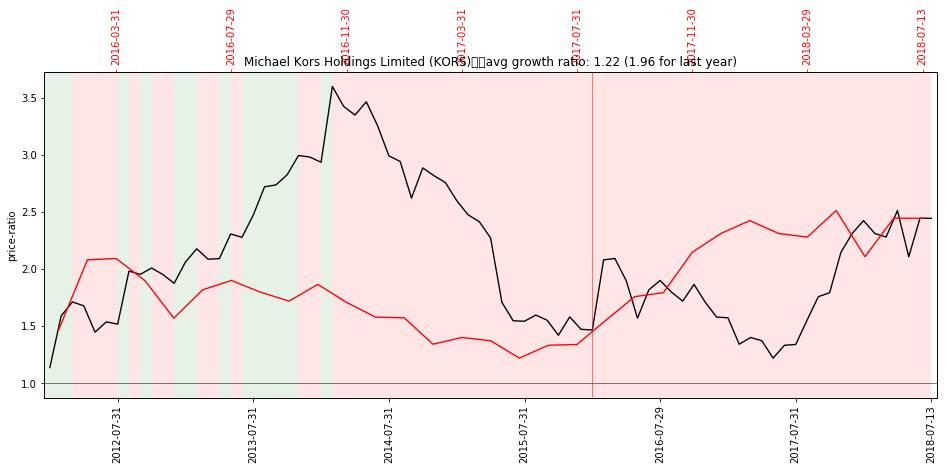

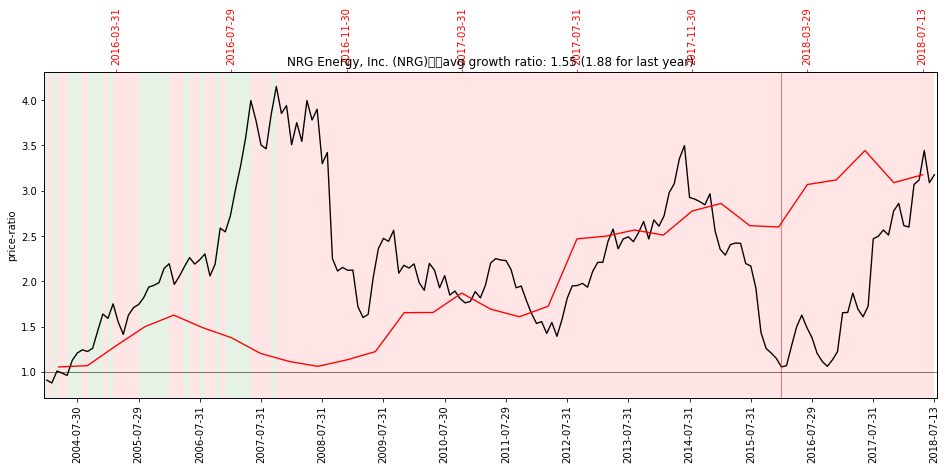

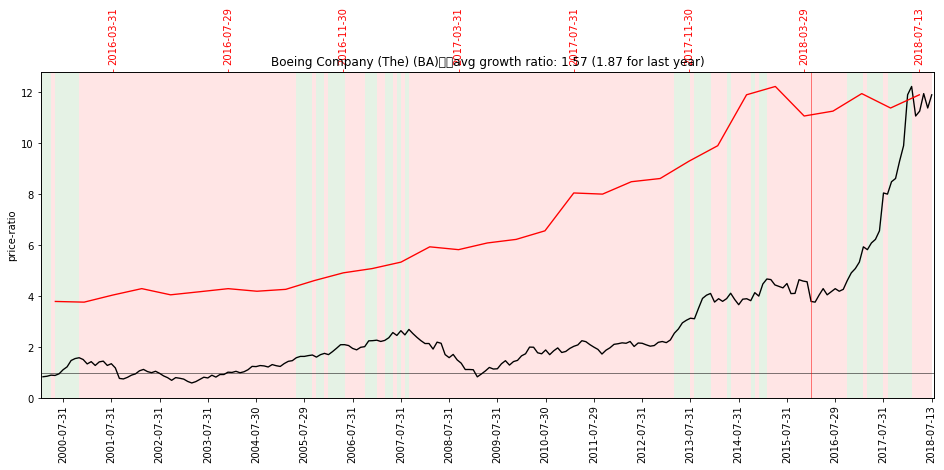

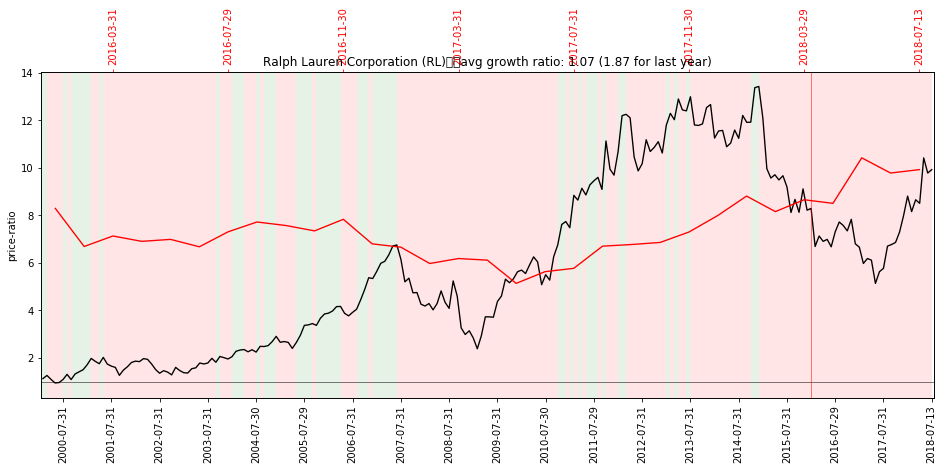

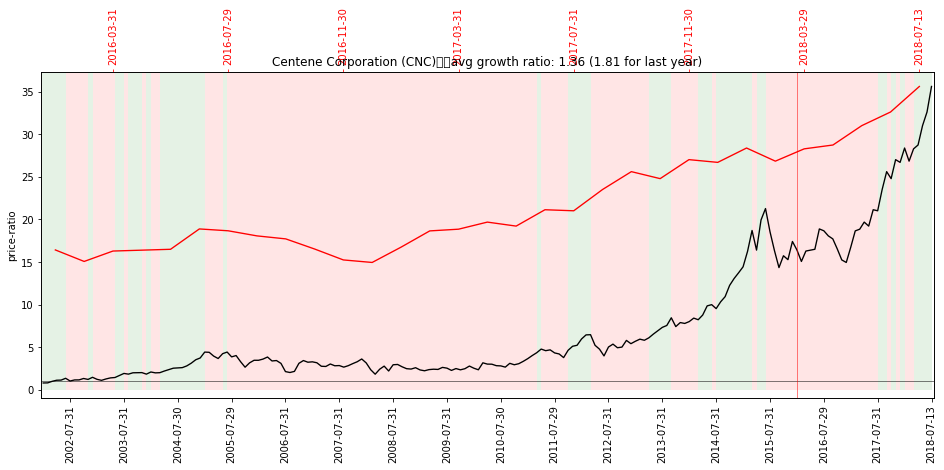

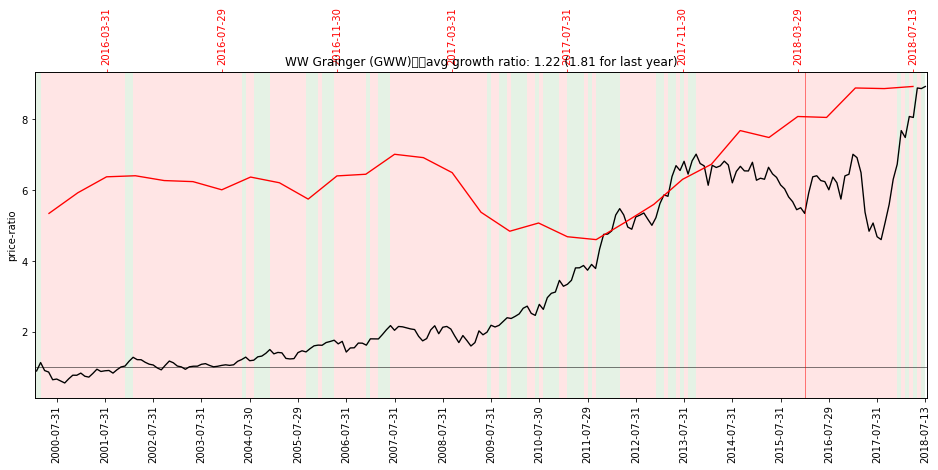

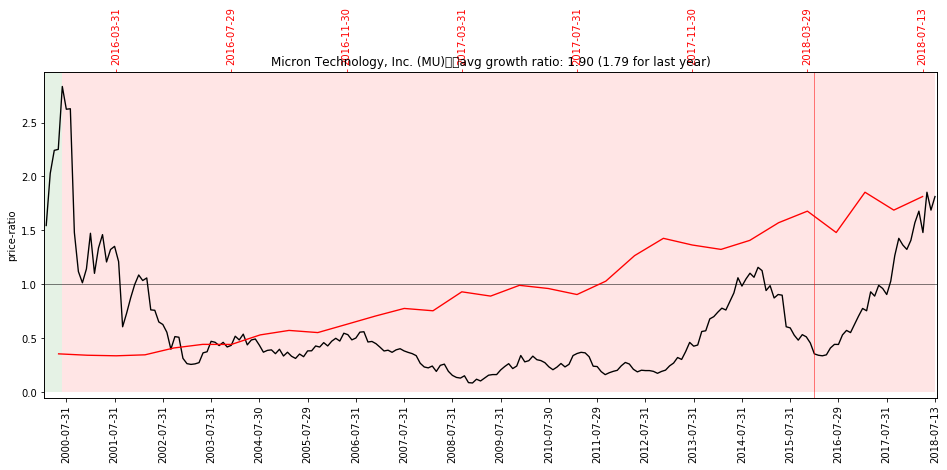

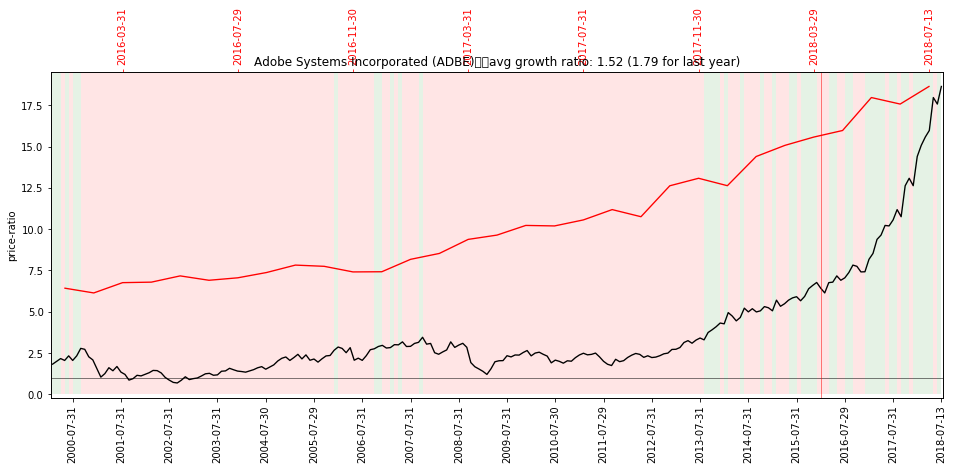

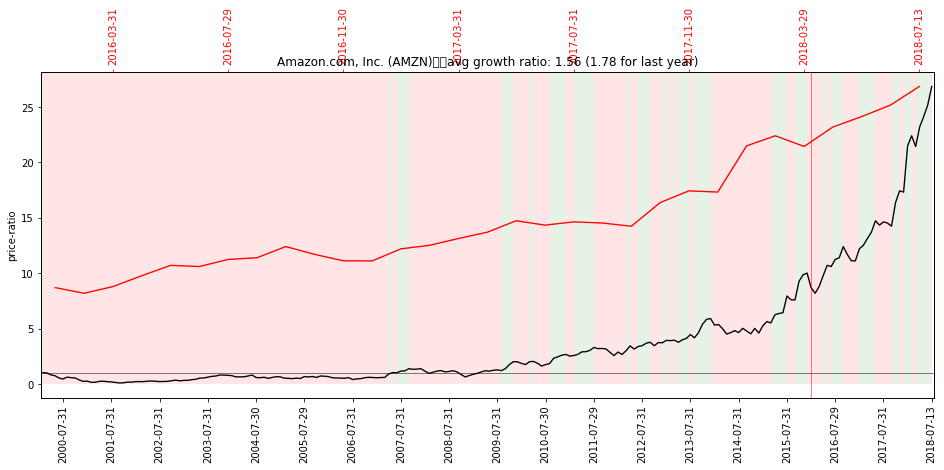

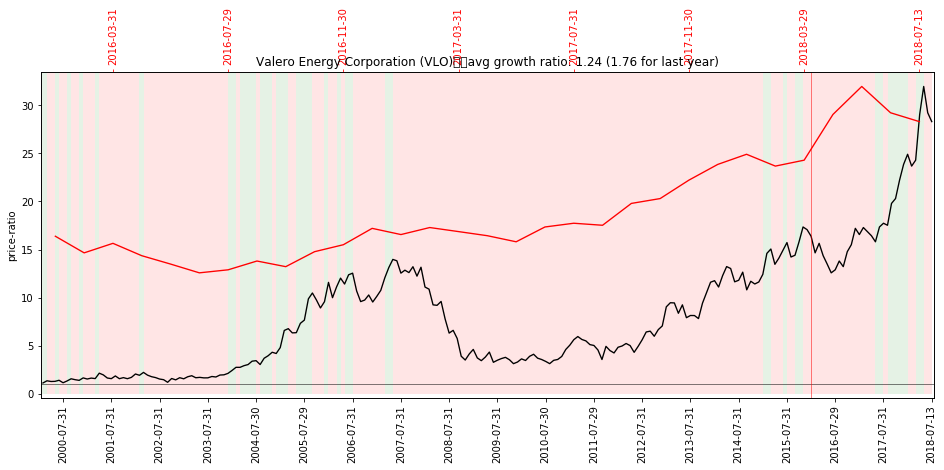

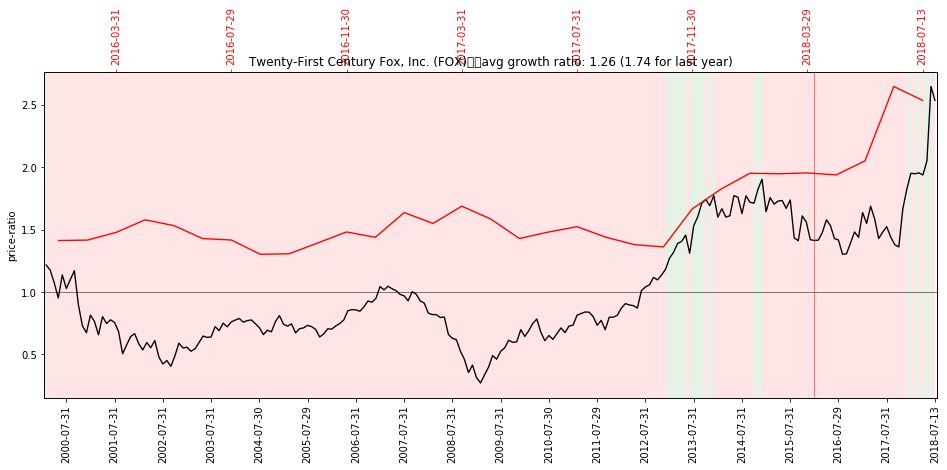

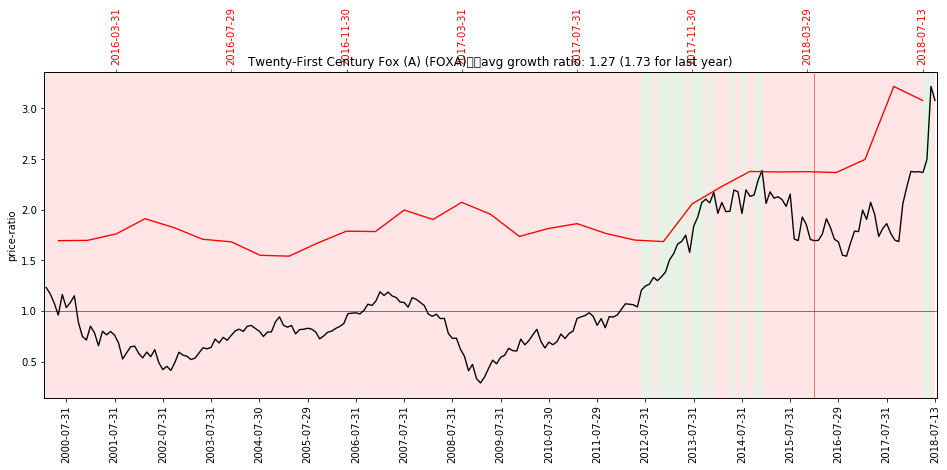

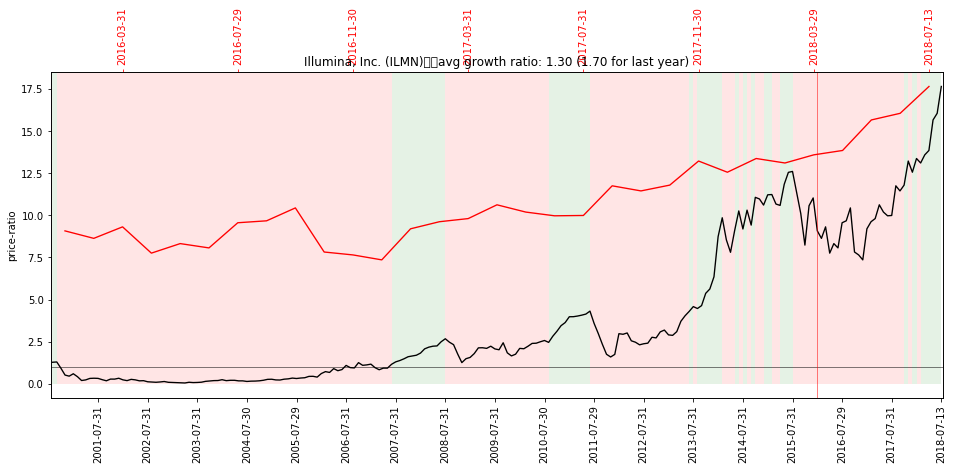

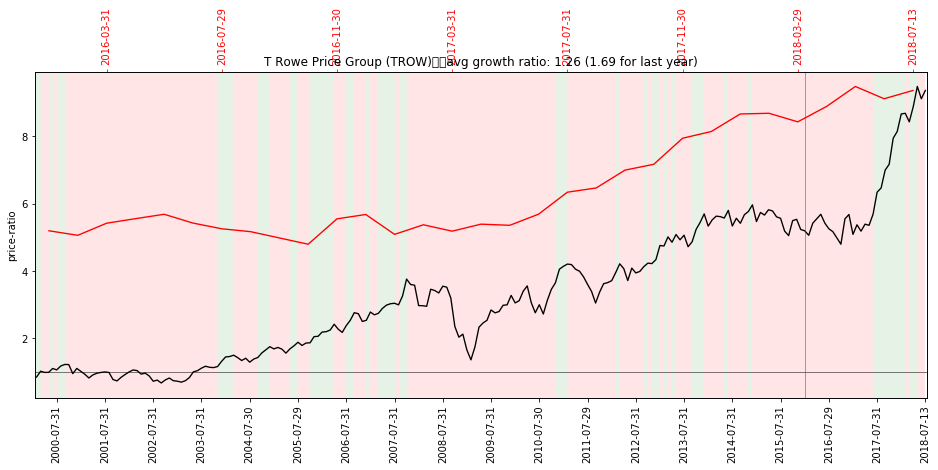

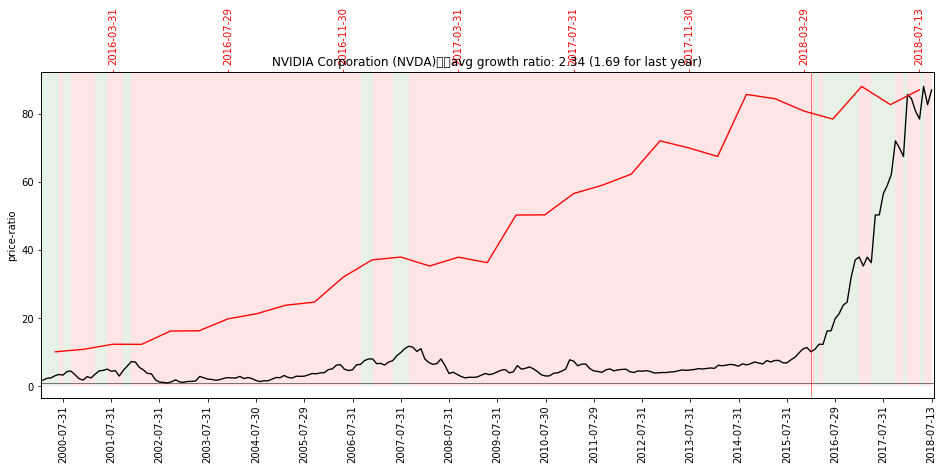

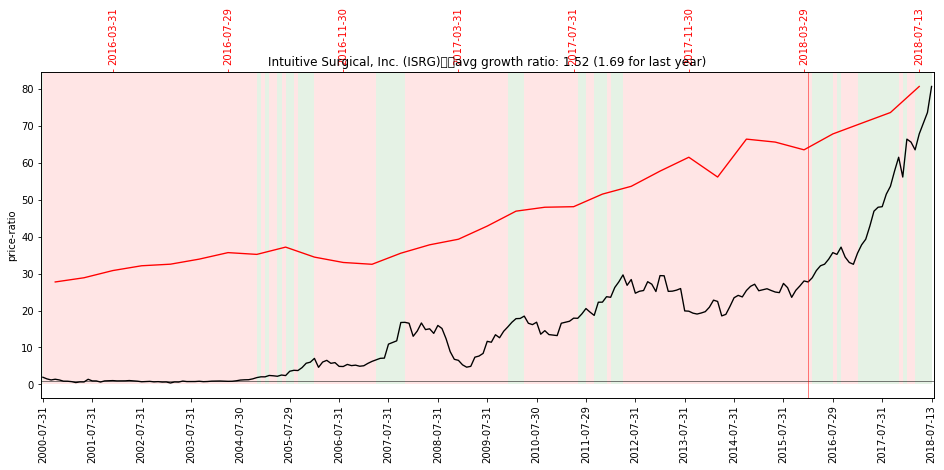

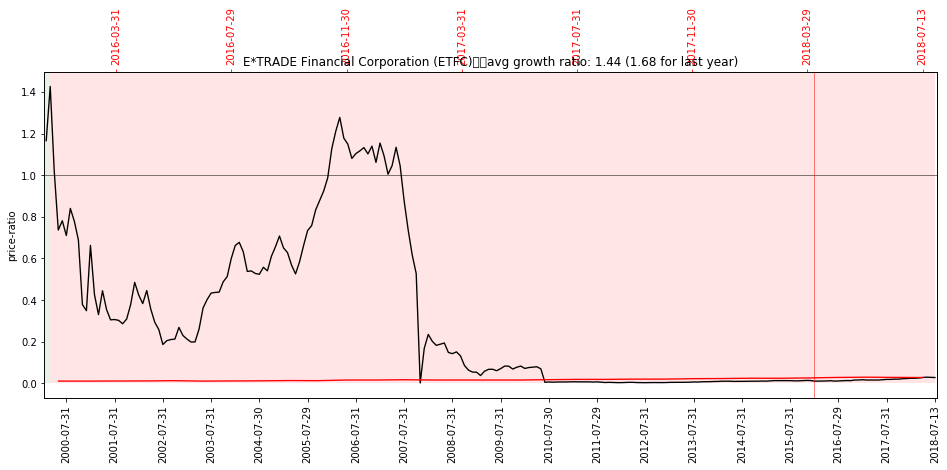

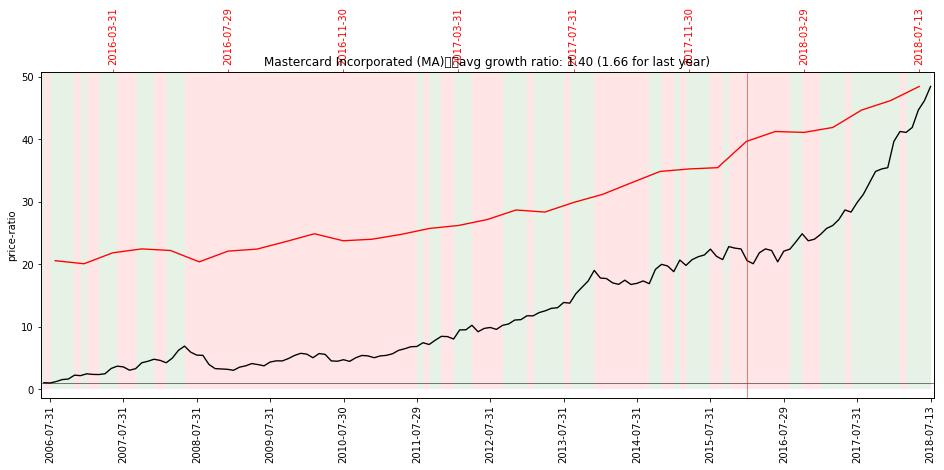

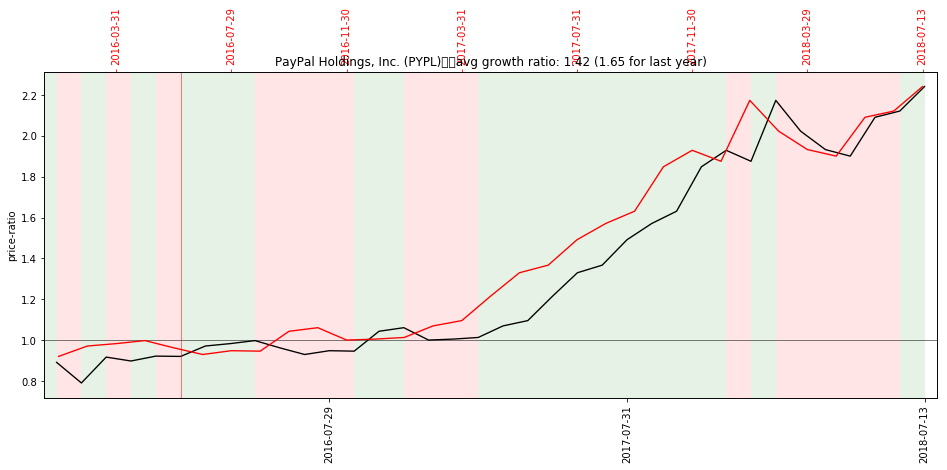

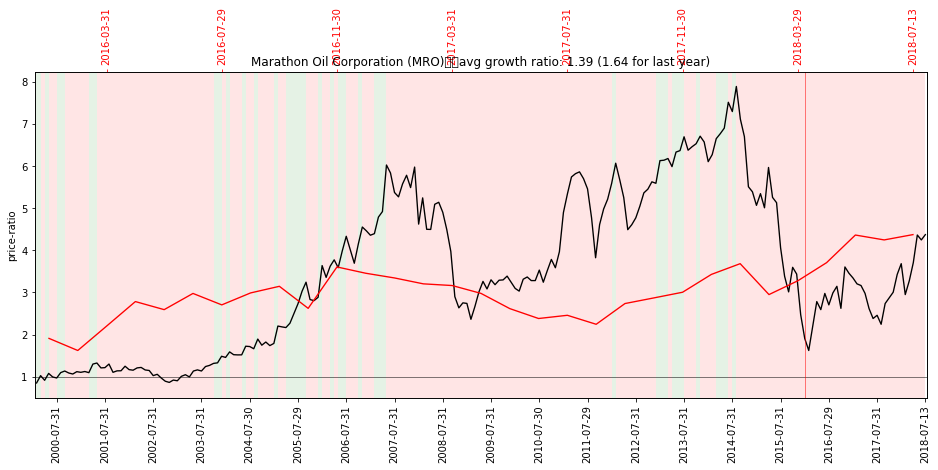

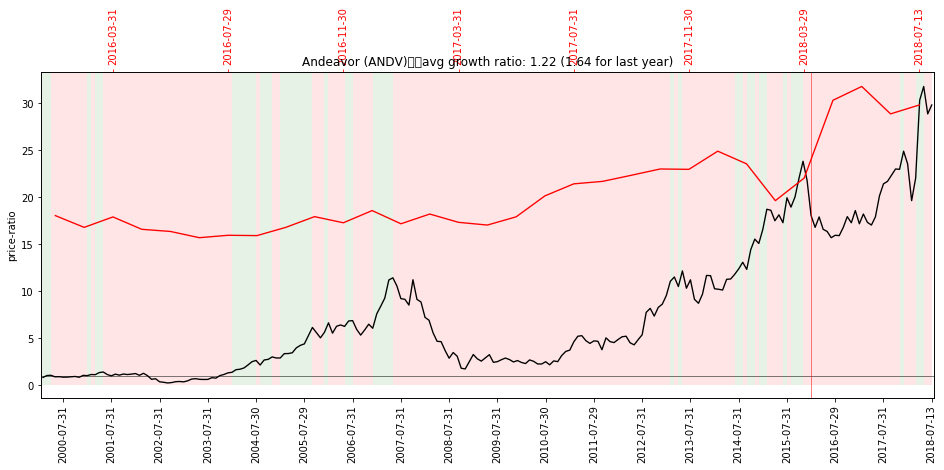

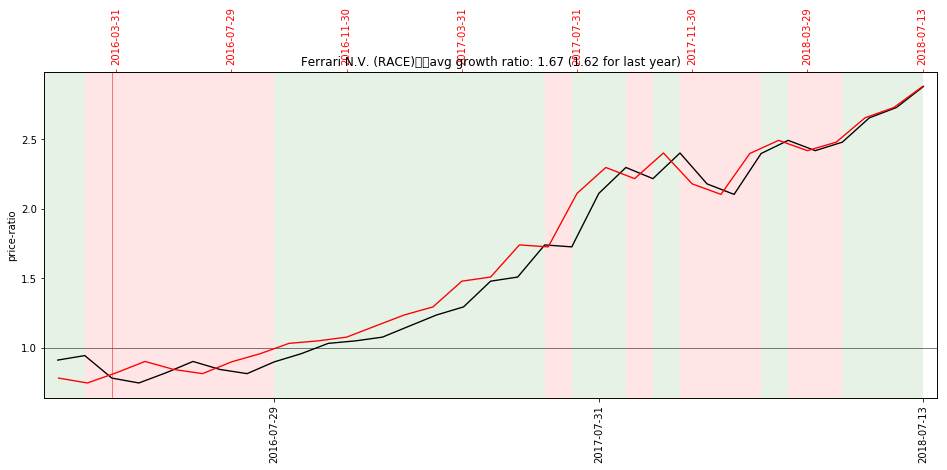

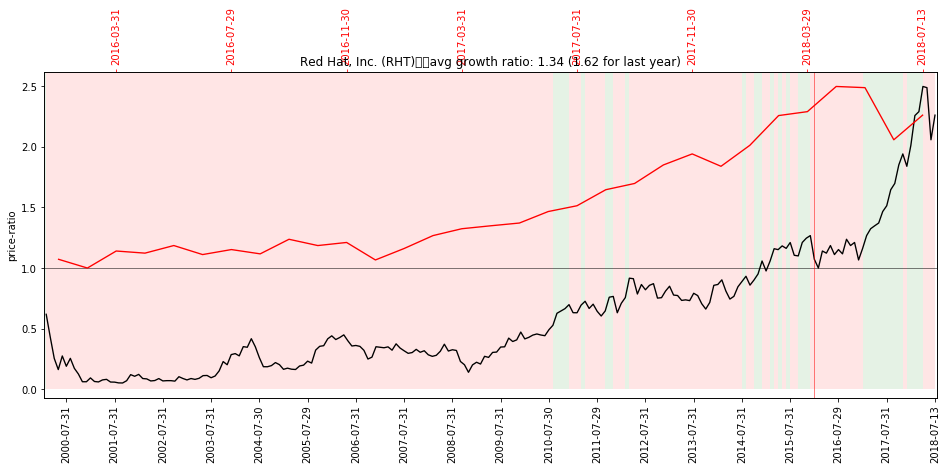

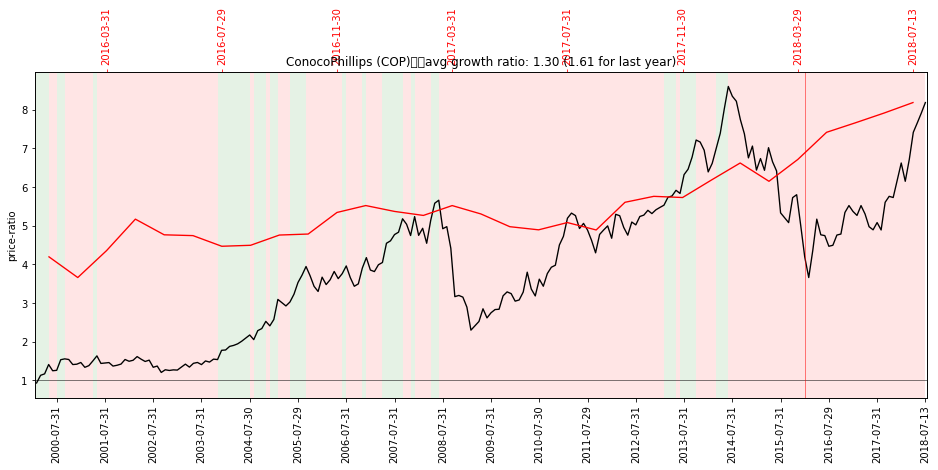

In [640]:
for (ratio, symbol) in price_ratio_growth_speed_top[:30]:
    render.draw_column(hist_per['all'], symbol, stocks['Name'][symbol], period = ('2016', '2100'), add = ['drop-periods'])

## Look at distribution of max drop-period value among symbols in different periods of hostory

In [334]:
def isnan(v):
    return v == math.nan or np.isnan(v)

def isnotnan(v):
    return not isnan(v)

def dist_in_periods(hist_per, column, aggregator):
    colors = ['green', 'pink', 'orange', 'red']    
    label = '{} distribution'.format(column)
    fig, axs = plt.subplots(ncols=4, nrows=2)
    fig.set_size_inches(16, 8)
    for row_n in range(2):
        for col_n in range(4):
            period_name = periods[row_n*4 + col_n][0]
            hp = hist_per[period_name]
            values = [*filter(isnotnan, [aggregator(h[column]) for h in hp.values()])]
            color = colors[col_n if row_n else 3 - col_n]
#             color = colors[col_n]
            p = sns.distplot(values, bins=20, kde=False, label=label, color=color, ax = axs[row_n][col_n])
            p.set_title(period_name)
            p.axes.axvline(np.percentile(values, 25), color='grey', linewidth=0.5)
            p.axes.axvline(np.median(values), color='grey', linewidth=0.5)
            p.axes.axvline(np.percentile(values, 75), color='grey', linewidth=0.5)
    plt.show()

/Users/fedor/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


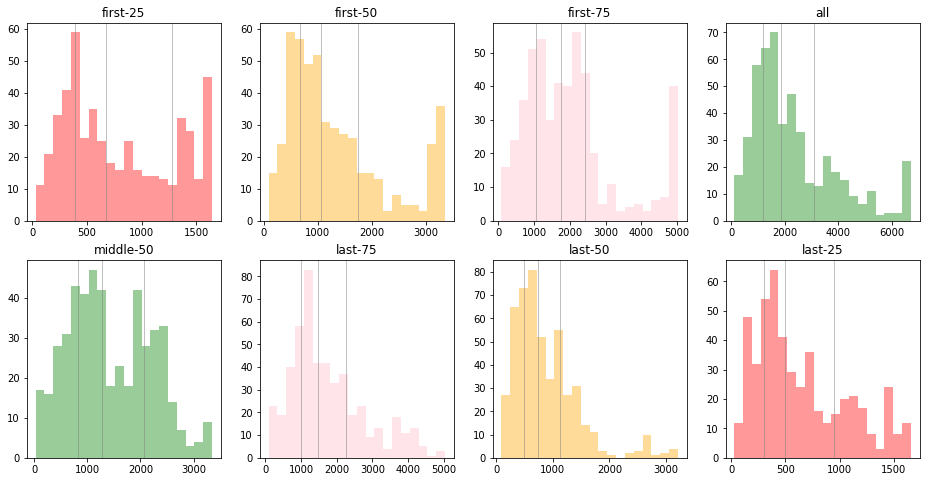

In [335]:
dist_in_periods(hist_per, 'drop-period', aggregator = max)

## Look at distribution of min price-drop value among symbols in different periods of hostory

/Users/fedor/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


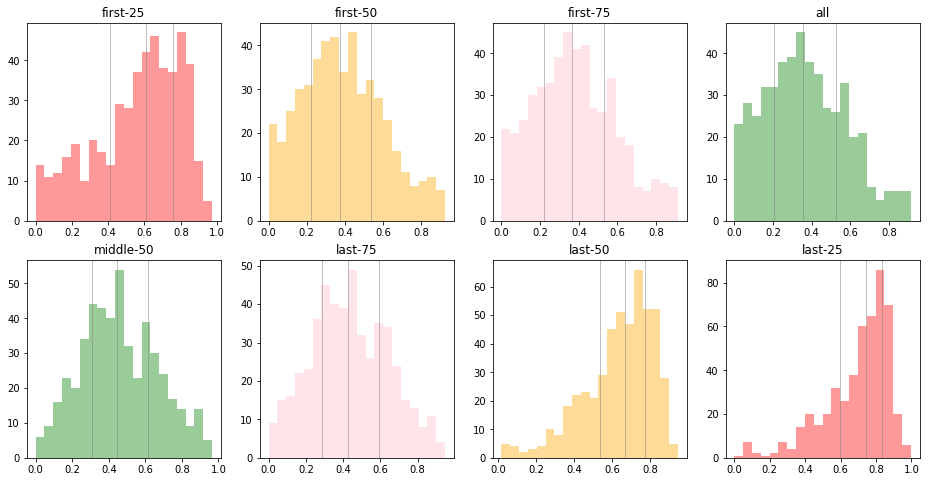

In [73]:
dist_in_periods(hist_per, 'price-drop', aggregator = min)

## Look at symbols with max drop-period < 180 days for for different periods

In [451]:
for (period_name, x) in abs_periods:
    hp = hist_per[period_name]
    drop_period_lt_180 = dict(filter(lambda item: item[1]['drop-period'].max() < 180, hp.items()))
    print('For period "{}" found {} symbols'.format(period_name, len(drop_period_lt_180)))

For period "last-15y" found 0 symbols
For period "last-10y" found 0 symbols
For period "last-7y" found 4 symbols
For period "last-5y" found 14 symbols
For period "last-3y" found 45 symbols
For period "last-2y" found 151 symbols


## Look at symbols with max drop-period < 180 days for last 5 years sorted by price-ratio growth in last year

In [642]:
def draw_symbols_sorted_by_price_growth_1y(hp, symbols, period = ('2016', '2100'), column = 'price-ratio'):
    sorted_symbols = sorted([(hp[symbol]['price-growth-1y'][-1], symbol) for symbol in symbols], reverse = True)
    for (ratio, symbol) in  sorted_symbols:
        render.draw_column(hp, symbol, stocks['Name'][symbol], period = period, column = column, add = ['drop-periods'])

Found 14 symbols


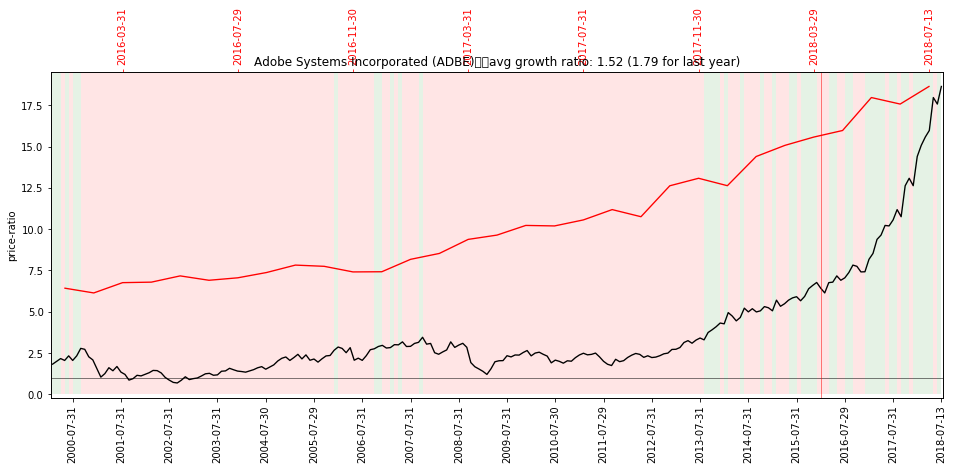

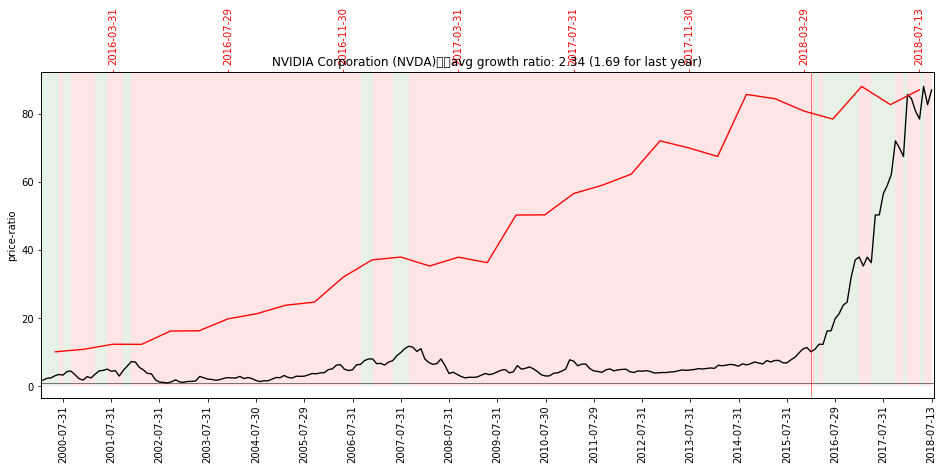

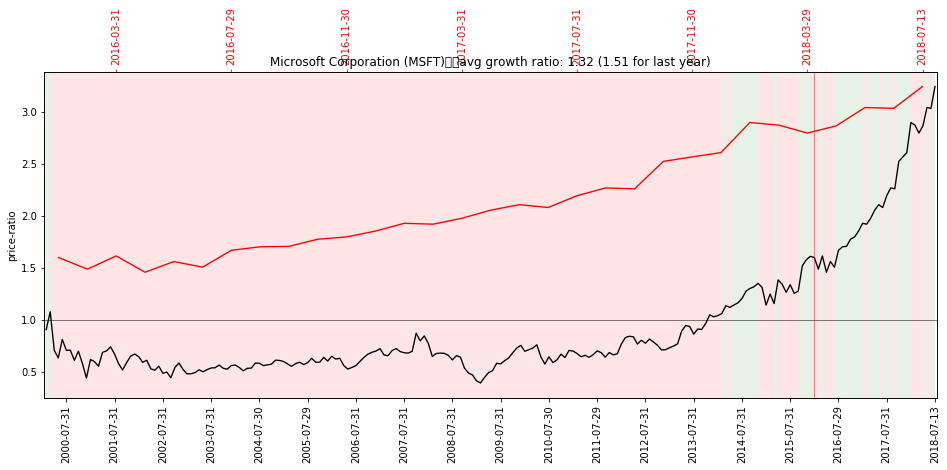

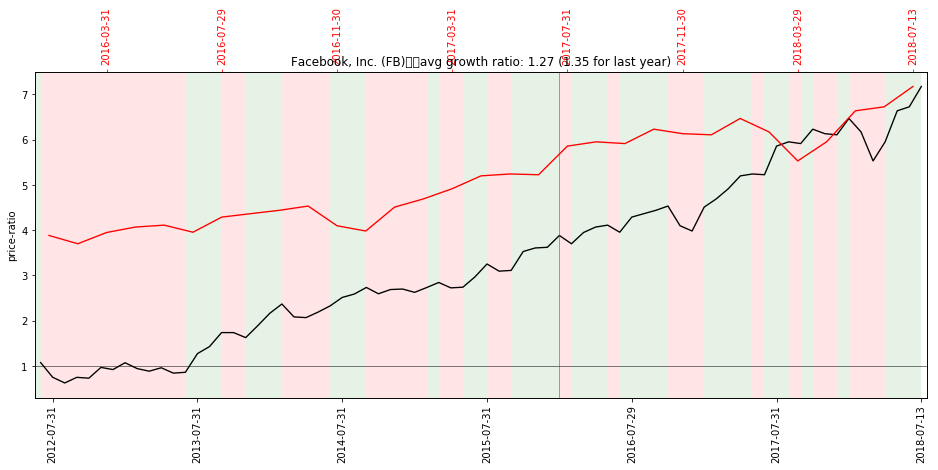

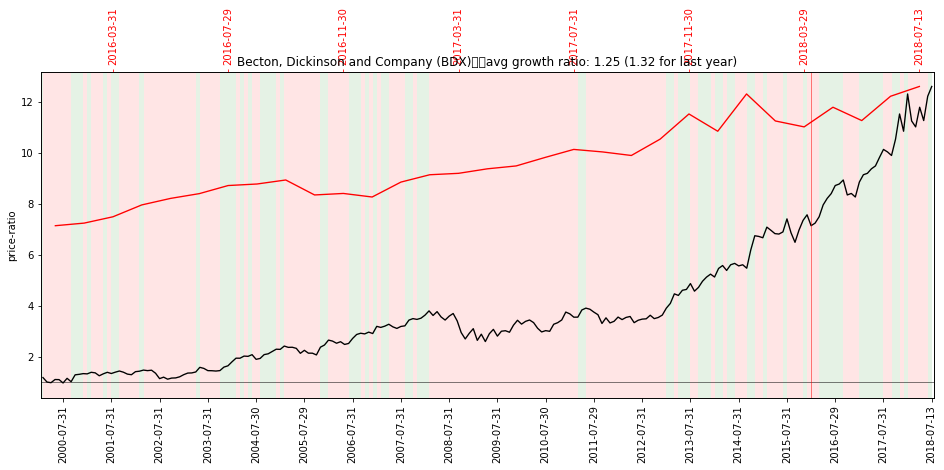

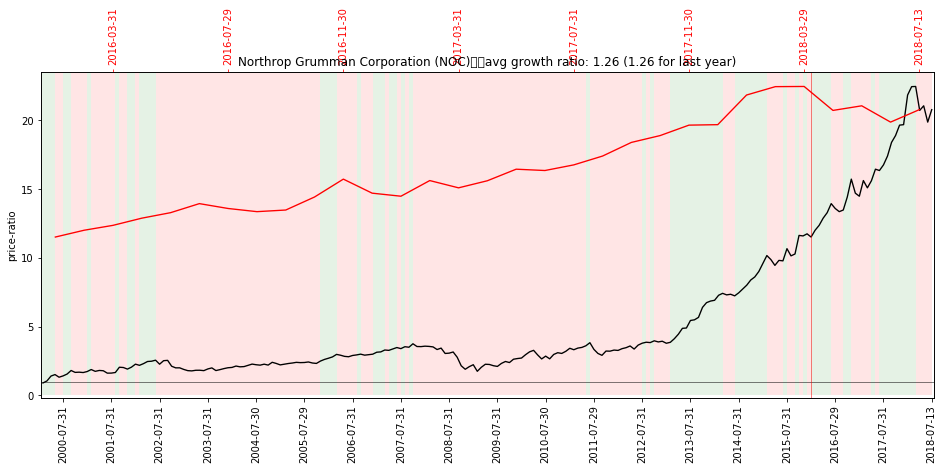

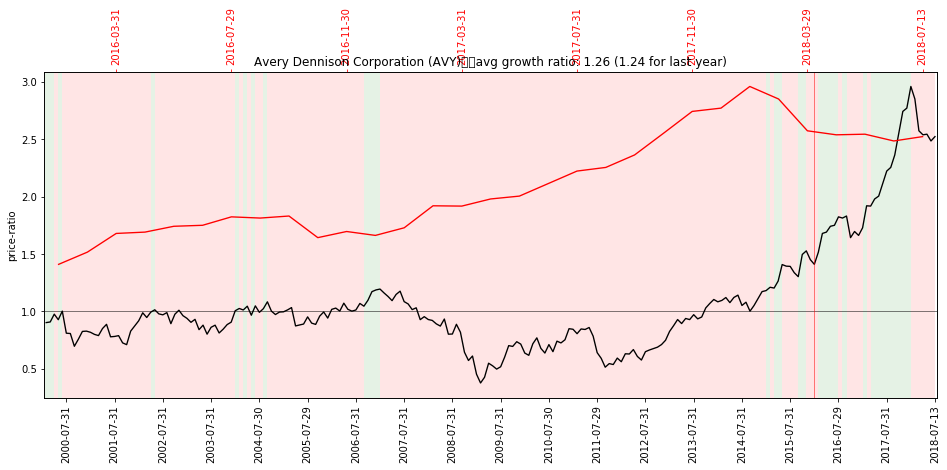

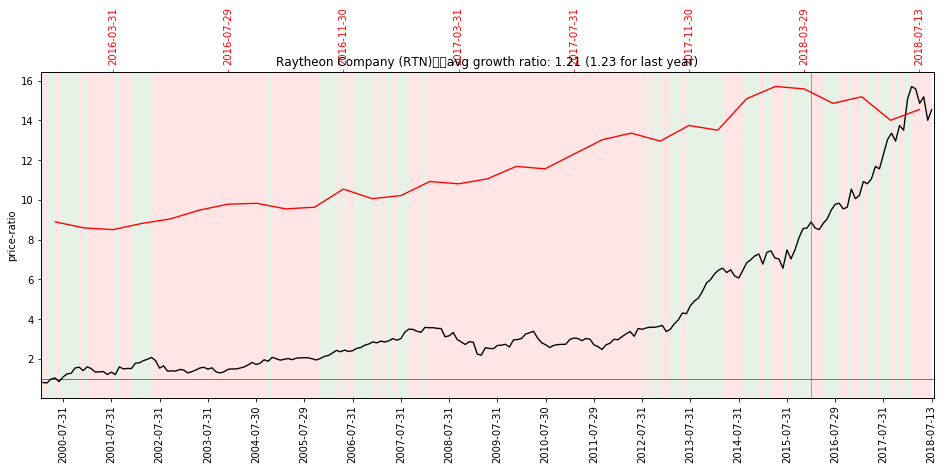

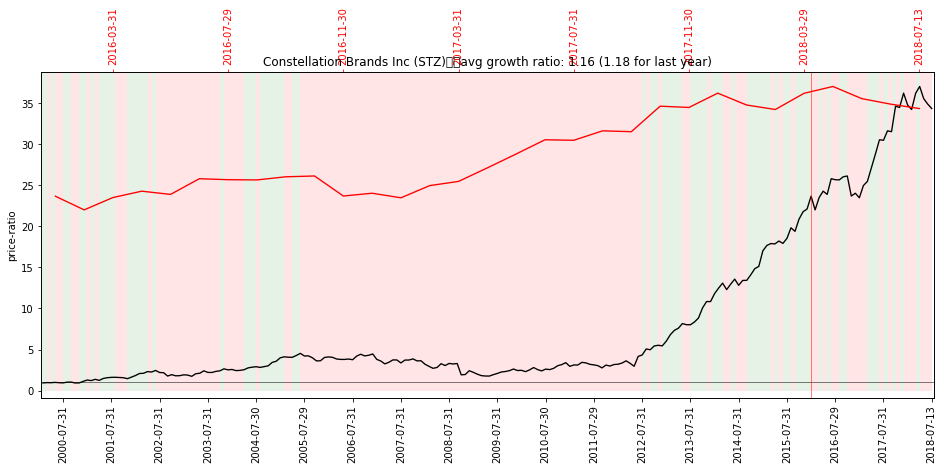

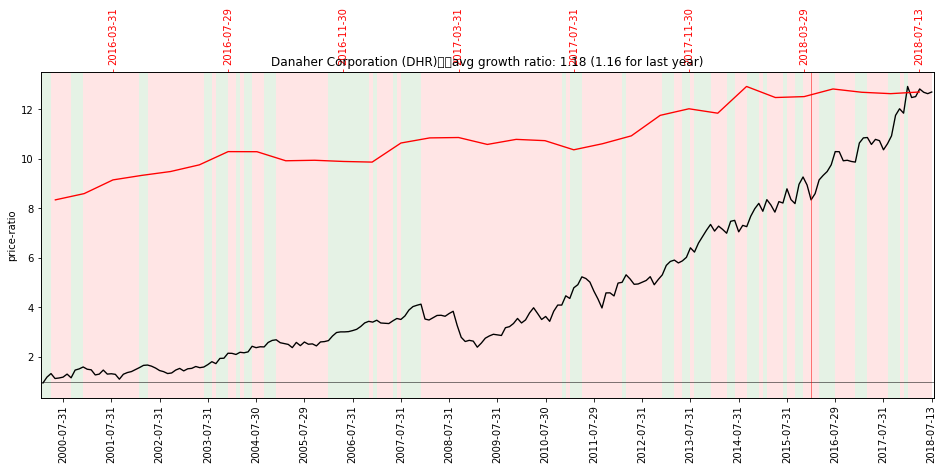

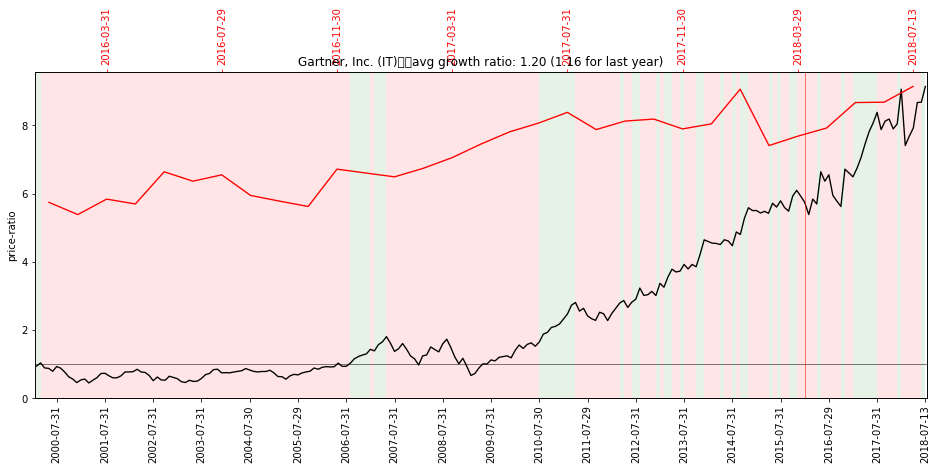

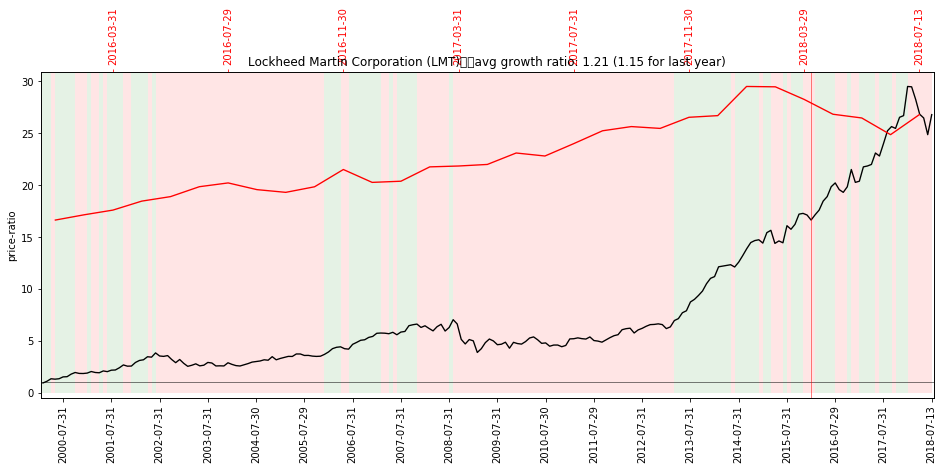

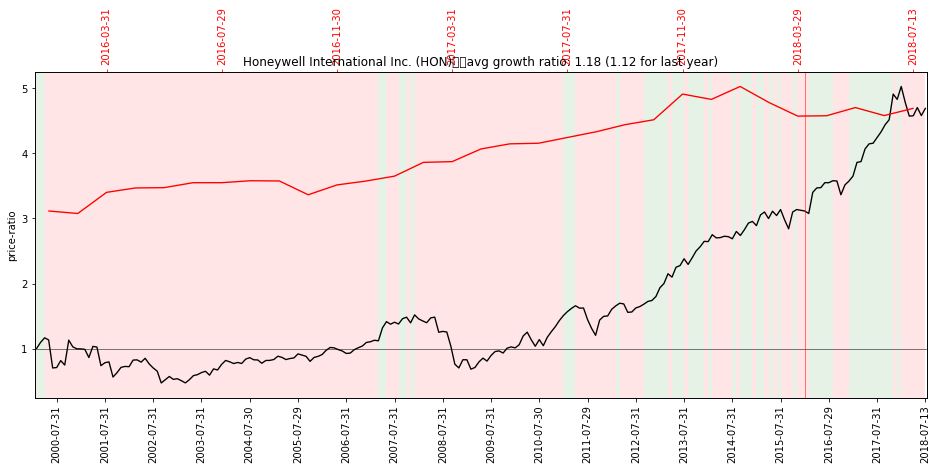

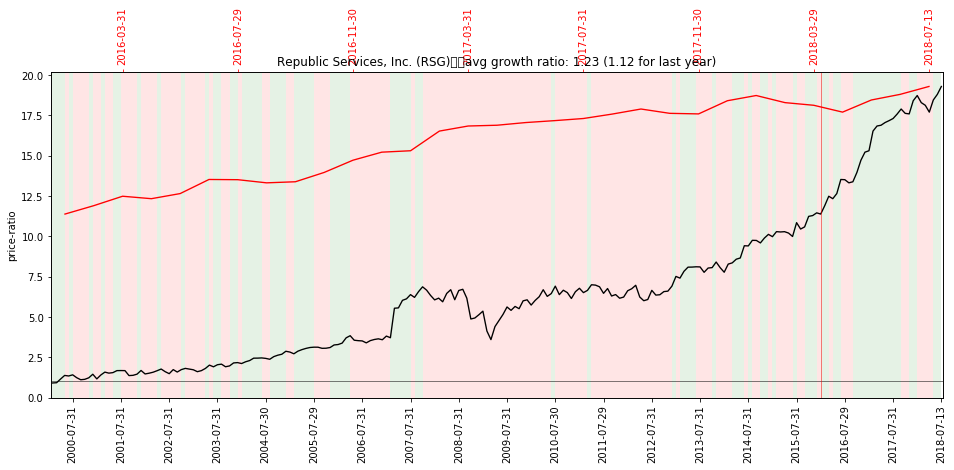

In [643]:
hp = hist_per['last-5y']
drop_period_lt_180 = dict(filter(lambda item: item[1]['drop-period'].max() < 180, hp.items()))
print('Found {} symbols'.format(len(drop_period_lt_180)))
draw_symbols_sorted_by_price_growth_1y(hist_per['all'], drop_period_lt_180.keys())

## Look at symbols with max drop-period < 270 days for for different periods

In [644]:
for (period_name, x) in abs_periods:
    hp = hist_per[period_name]
    drop_period_lt_270 = dict(filter(lambda item: item[1]['drop-period'].max() < 270, hp.items()))
    print('For period "{}" found {} symbols'.format(period_name, len(drop_period_lt_270)))

For period "last-15y" found 0 symbols
For period "last-10y" found 1 symbols
For period "last-7y" found 26 symbols
For period "last-5y" found 49 symbols
For period "last-3y" found 133 symbols
For period "last-2y" found 275 symbols


## Look at symbols with max drop-period < 270 days for last 7 years sorted by price-ratio growth in last year

Found 26 symbols


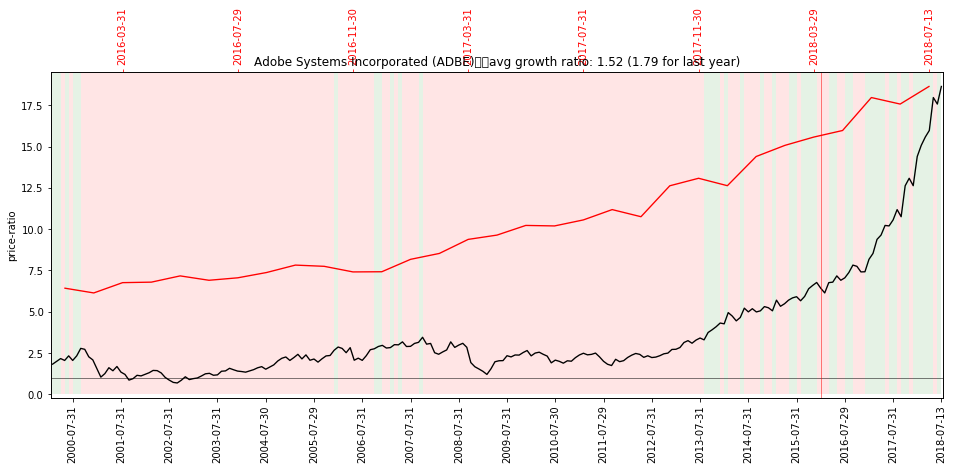

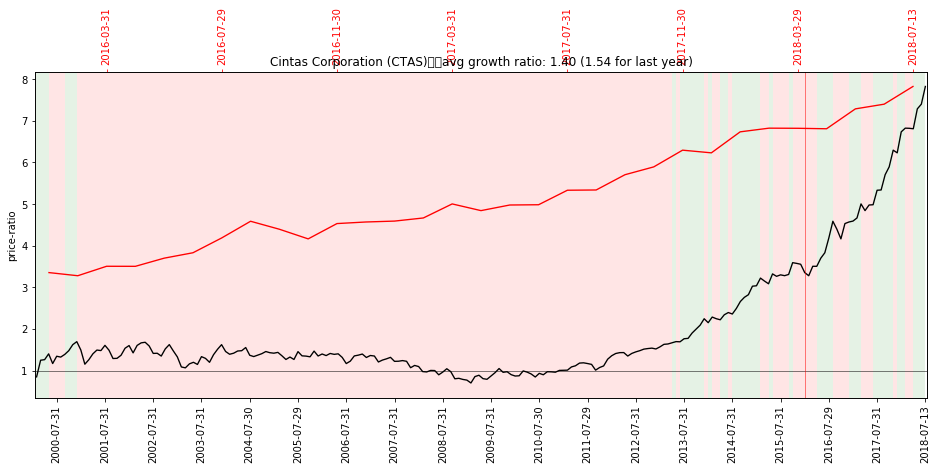

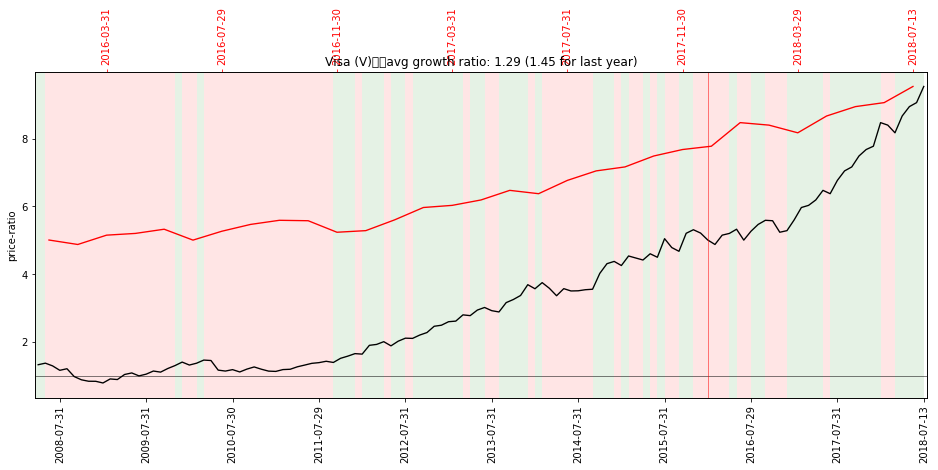

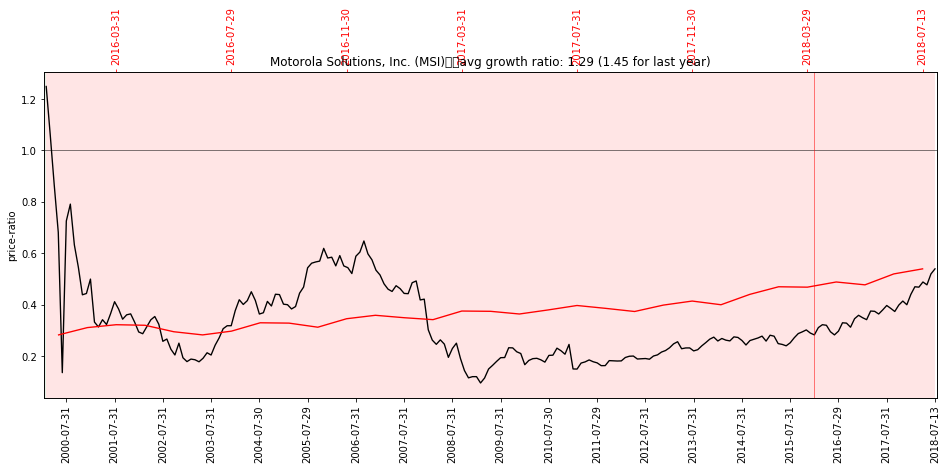

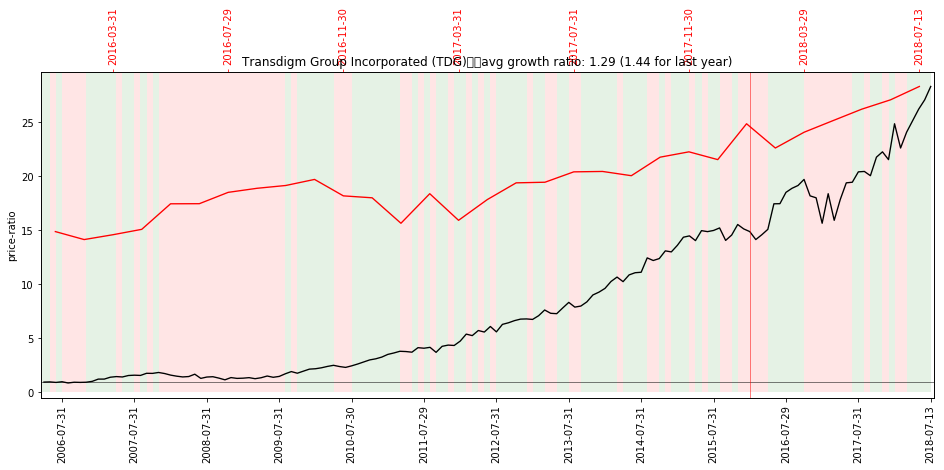

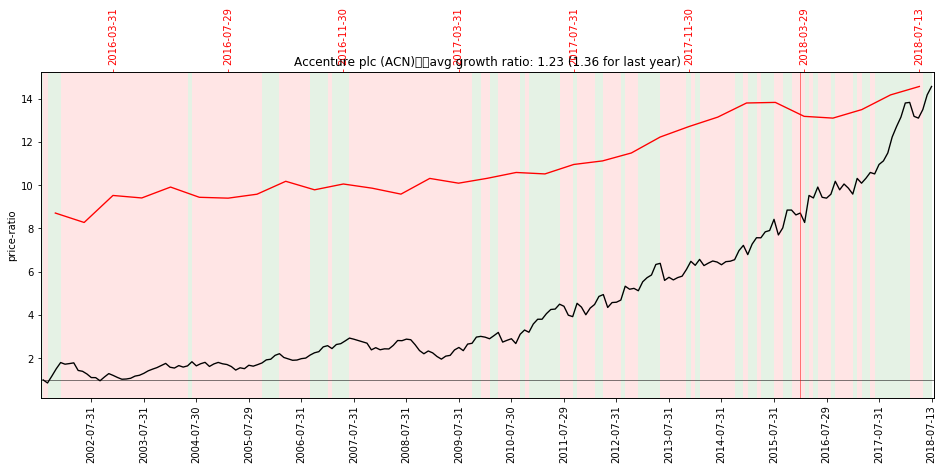

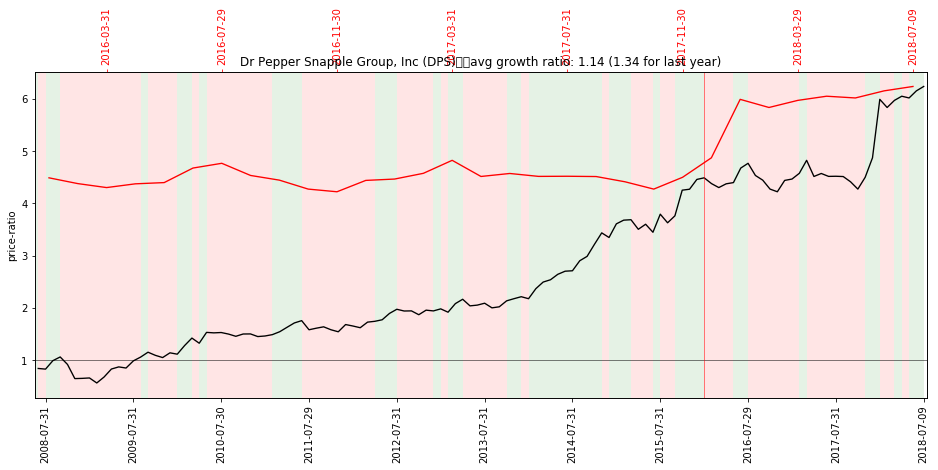

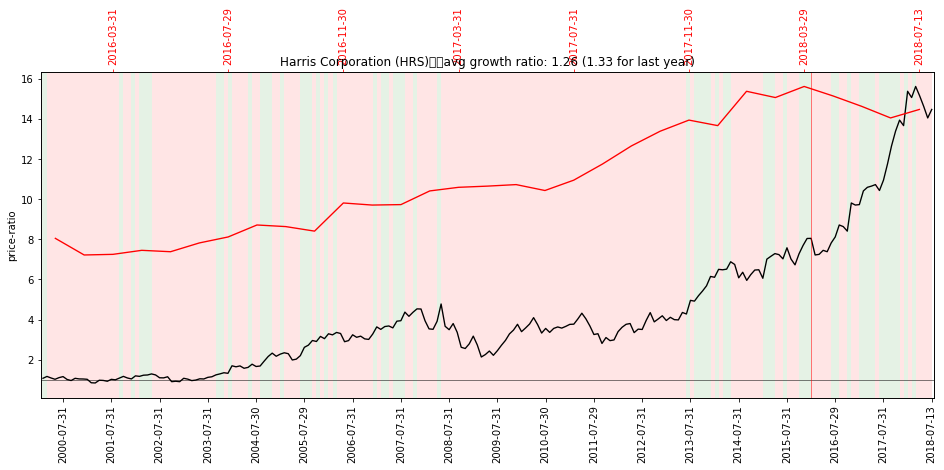

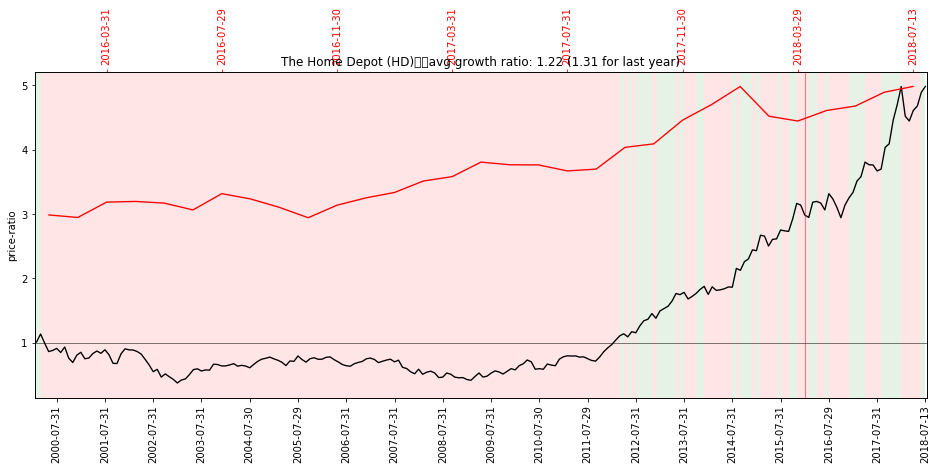

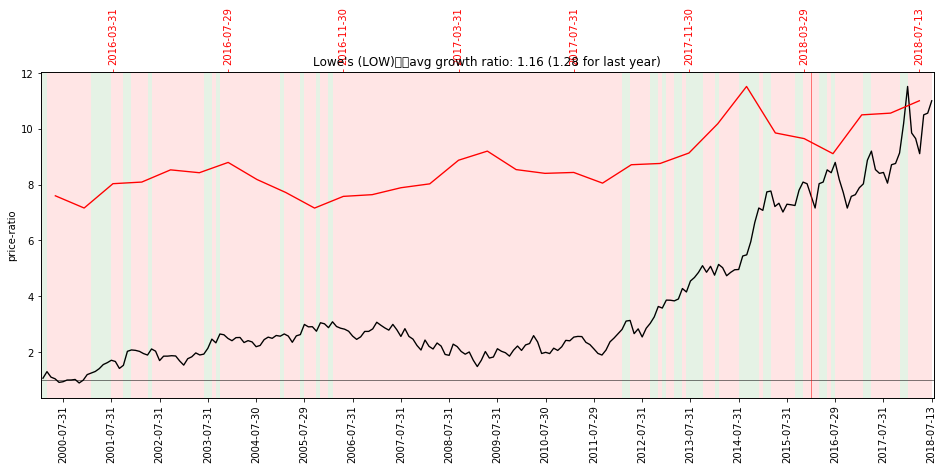

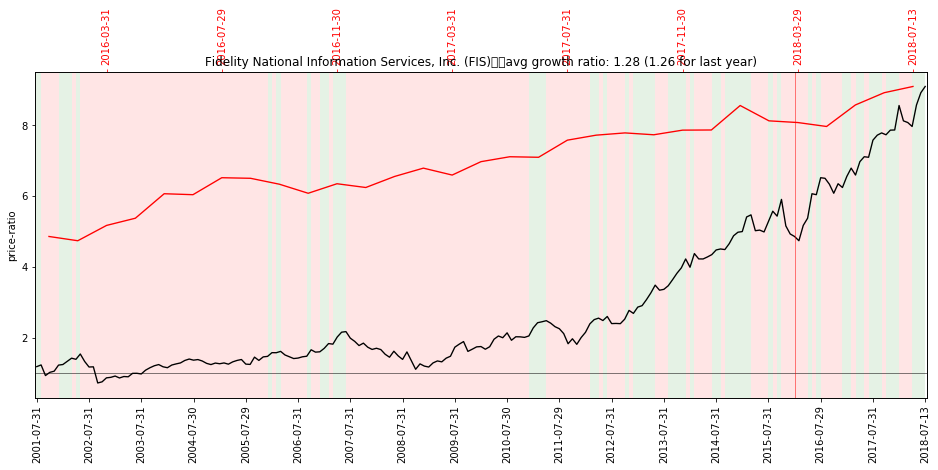

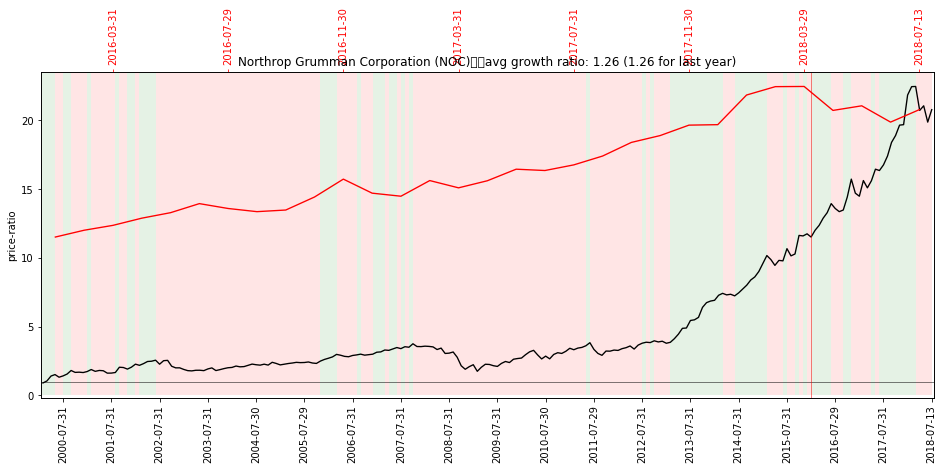

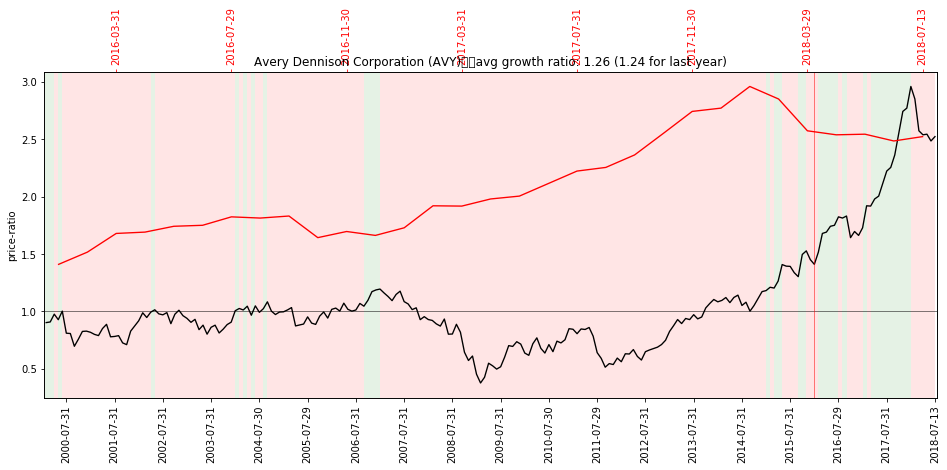

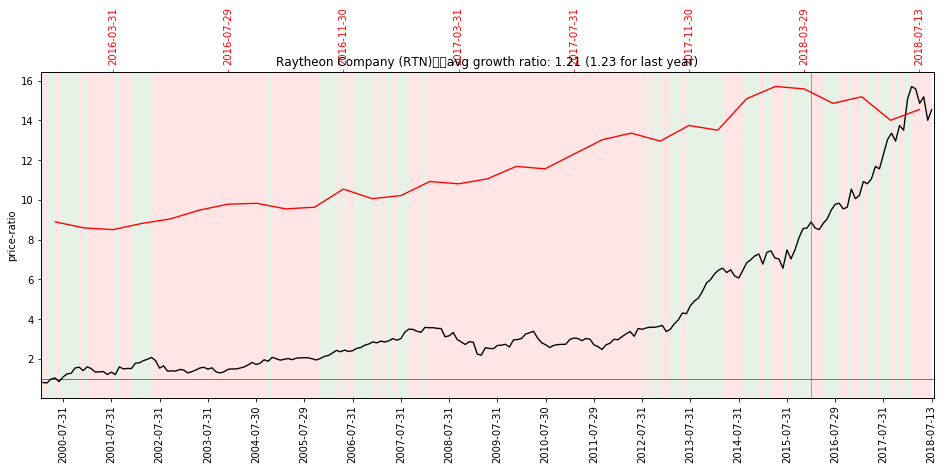

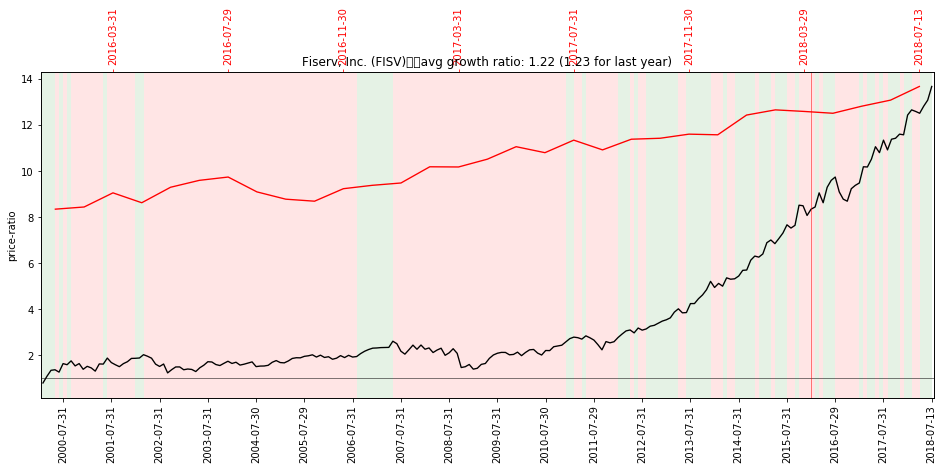

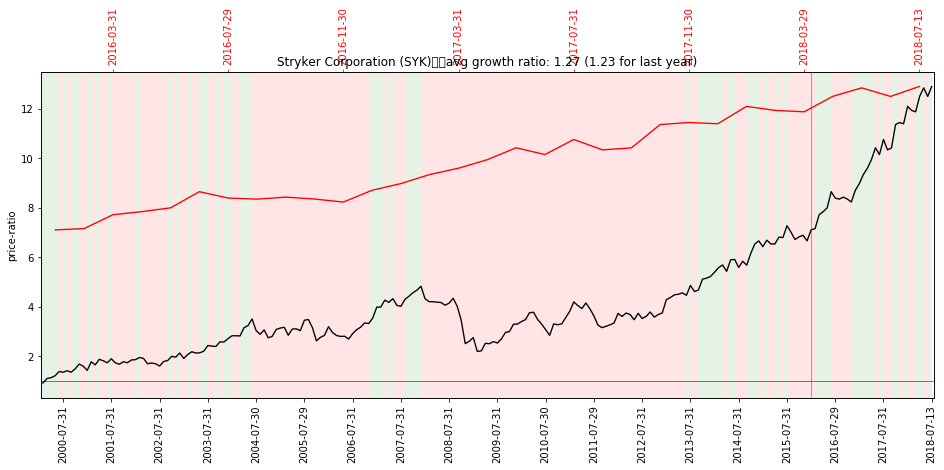

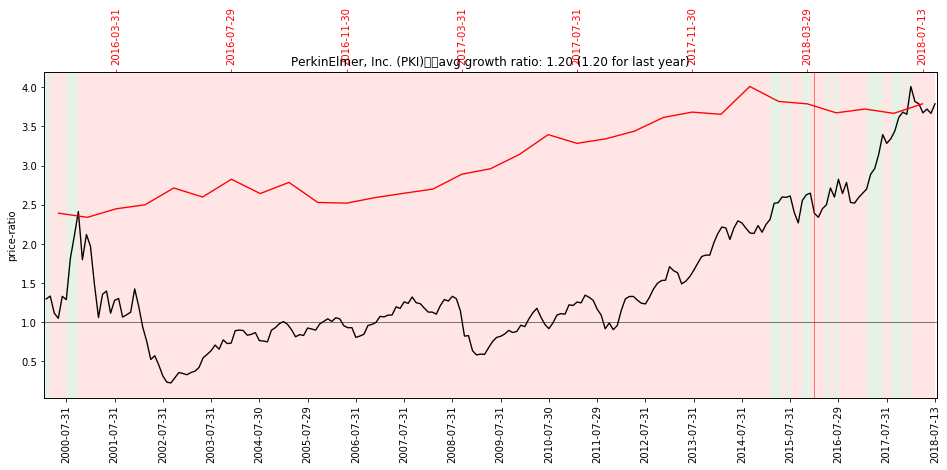

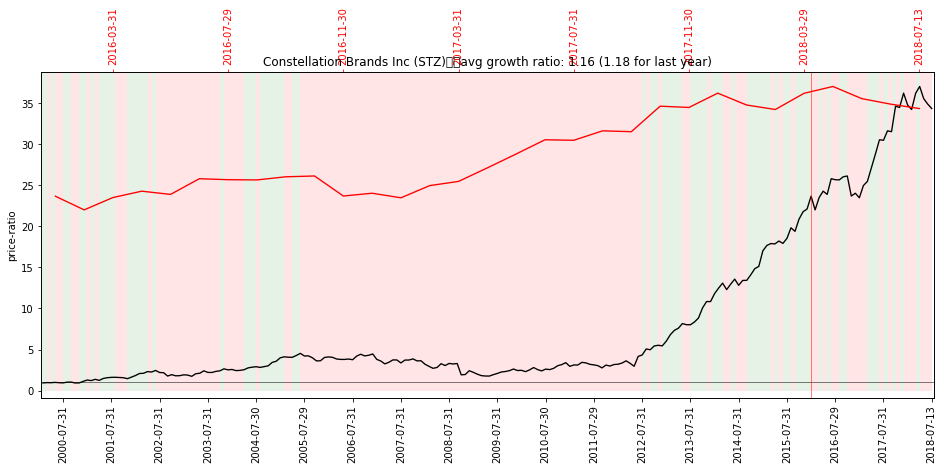

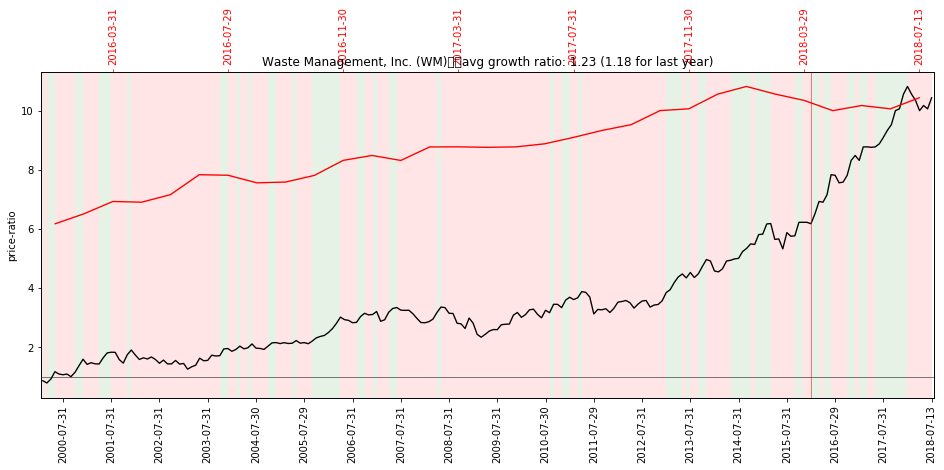

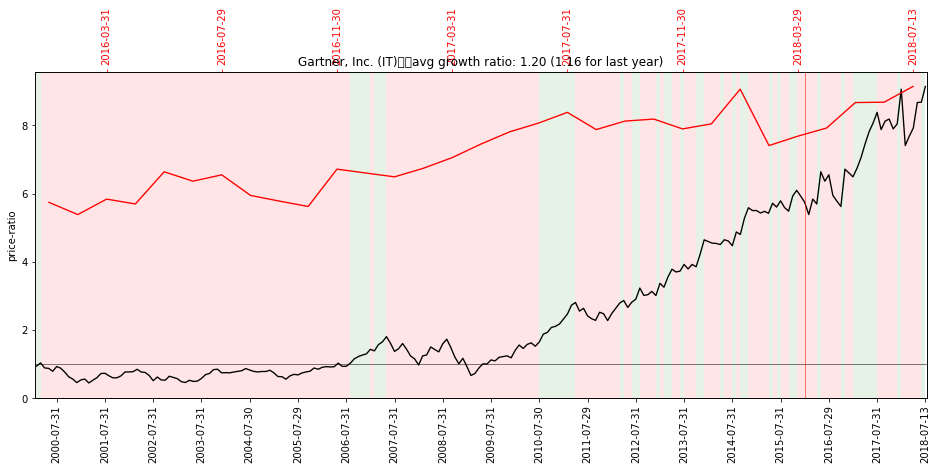

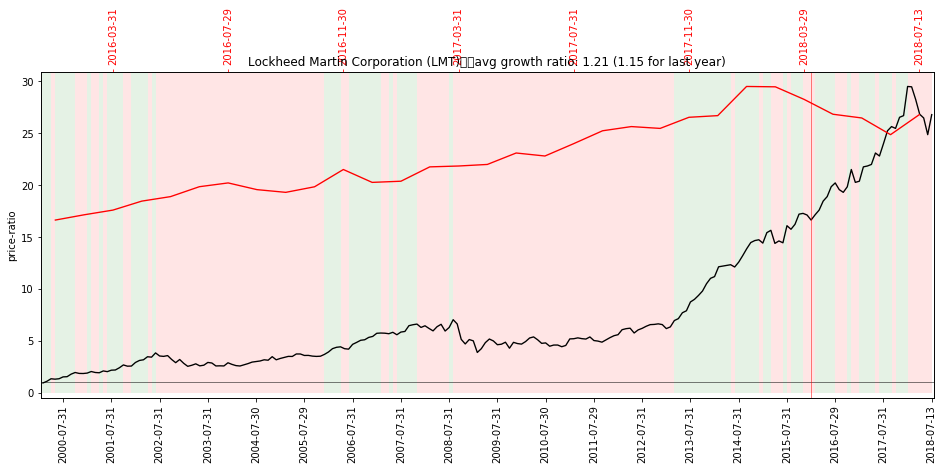

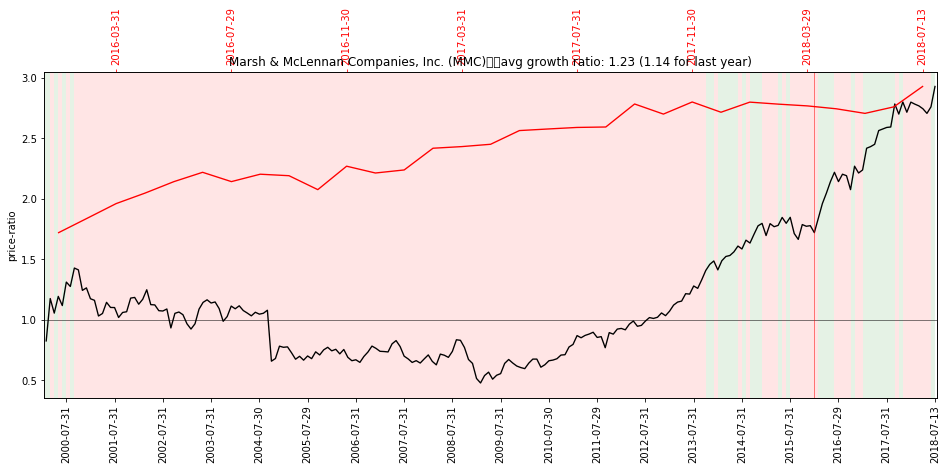

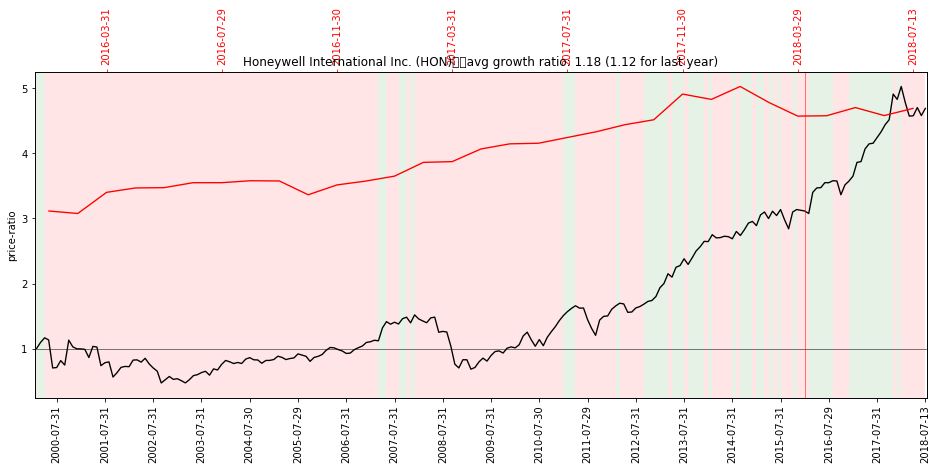

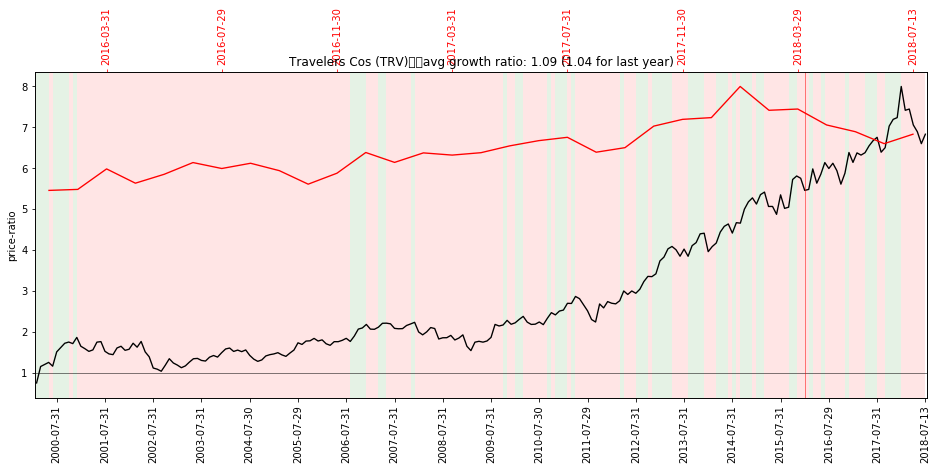

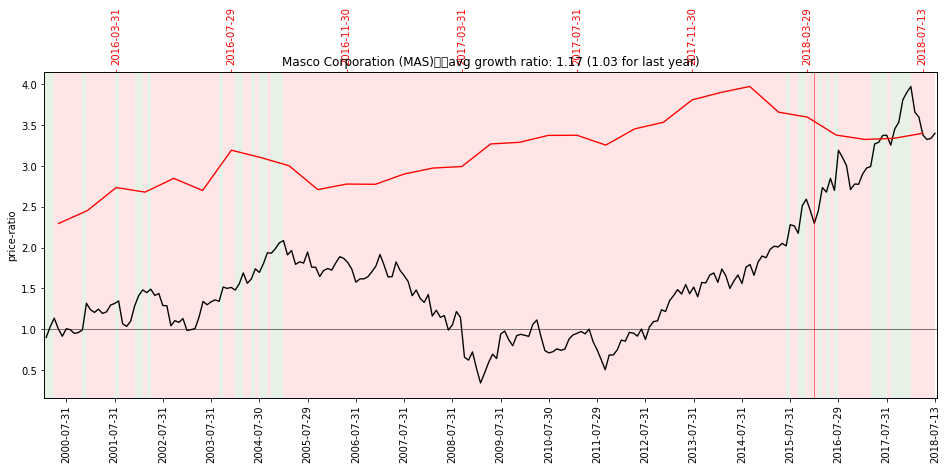

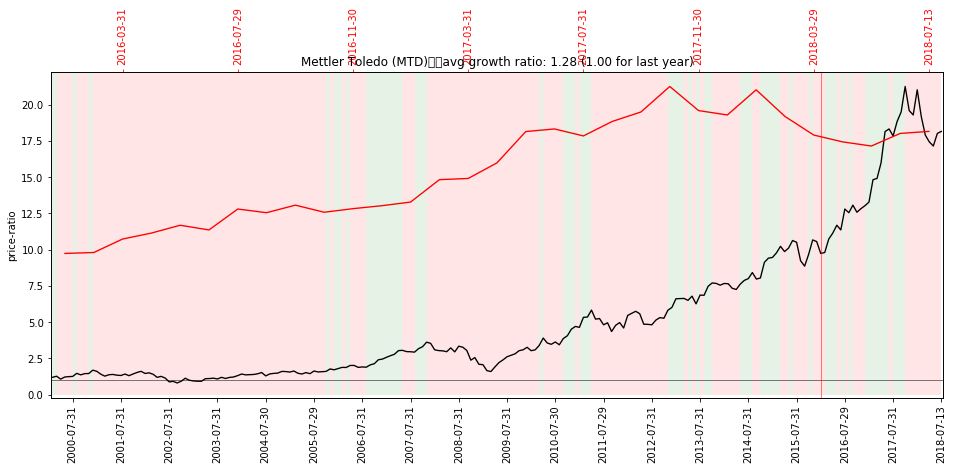

In [645]:
hp = hist_per['last-7y']
drop_period_lt_270 = dict(filter(lambda item: item[1]['drop-period'].max() < 270, hp.items()))
print('Found {} symbols'.format(len(drop_period_lt_270)))
draw_symbols_sorted_by_price_growth_1y(hist_per['all'], drop_period_lt_270.keys())

## Look at symbols with max drop-period < 365 days for for different periods

In [646]:
for (period_name, x) in abs_periods:
    hp = hist_per[period_name]
    drop_period_lt_365 = dict(filter(lambda item: item[1]['drop-period'].max() < 365, hp.items()))
    print('For period "{}" found {} symbols'.format(period_name, len(drop_period_lt_365)))

For period "last-15y" found 0 symbols
For period "last-10y" found 12 symbols
For period "last-7y" found 83 symbols
For period "last-5y" found 110 symbols
For period "last-3y" found 212 symbols
For period "last-2y" found 341 symbols


## Look at symbols with max drop-period < 365 days for last 10 years sorted by price-ratio growth in last year

Found 12 symbols


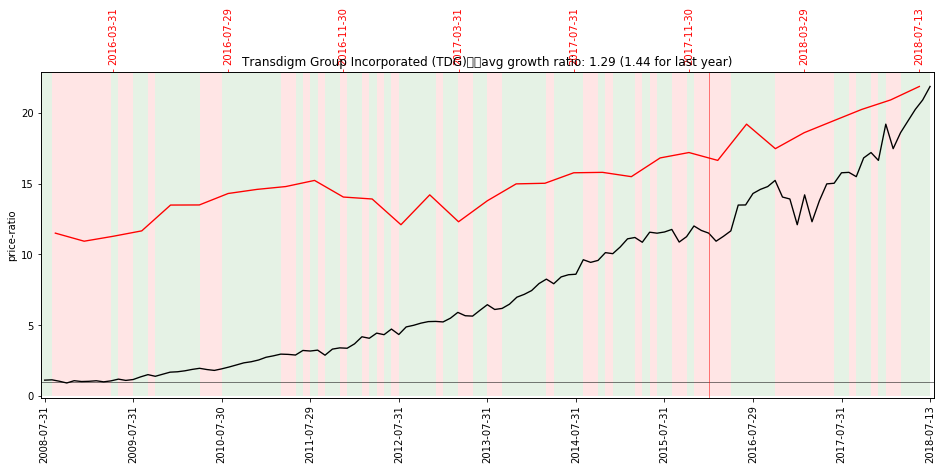

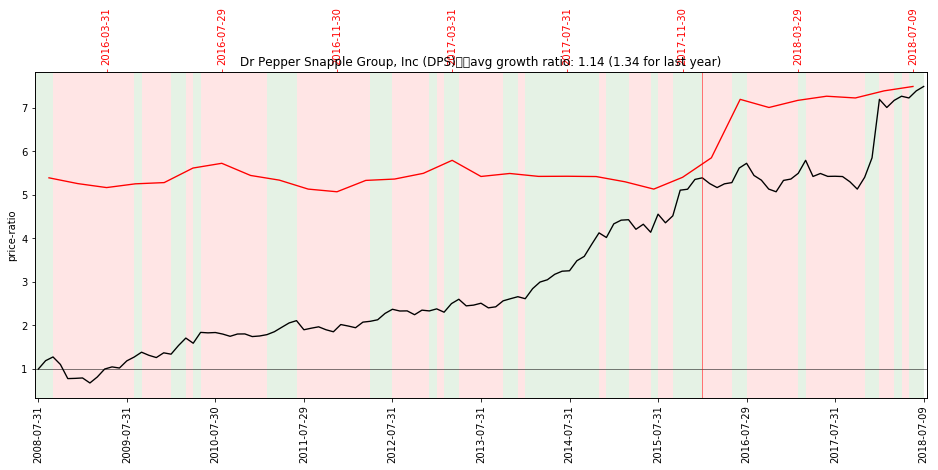

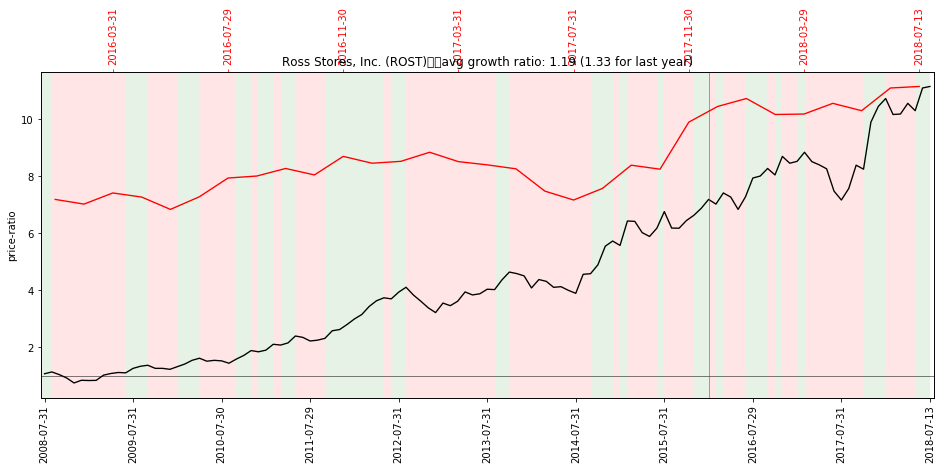

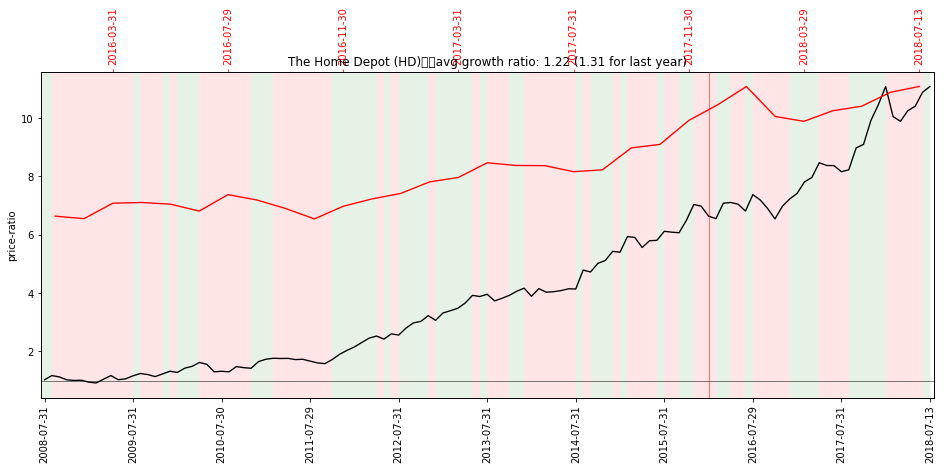

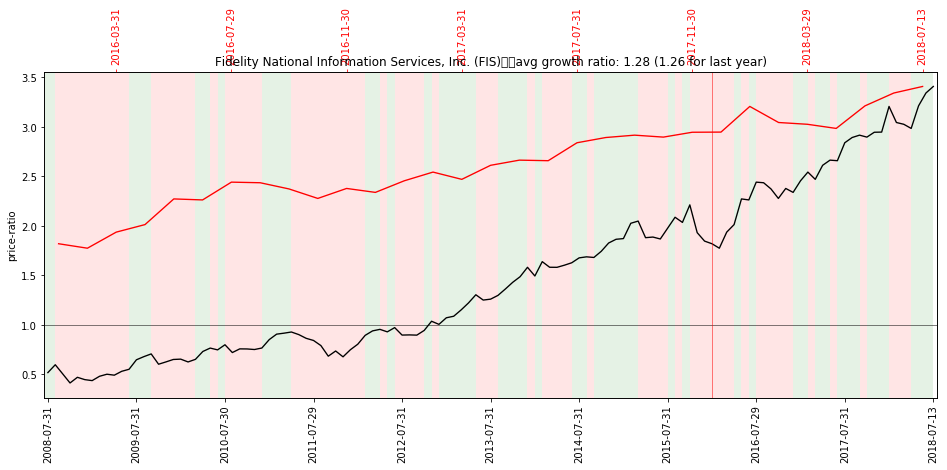

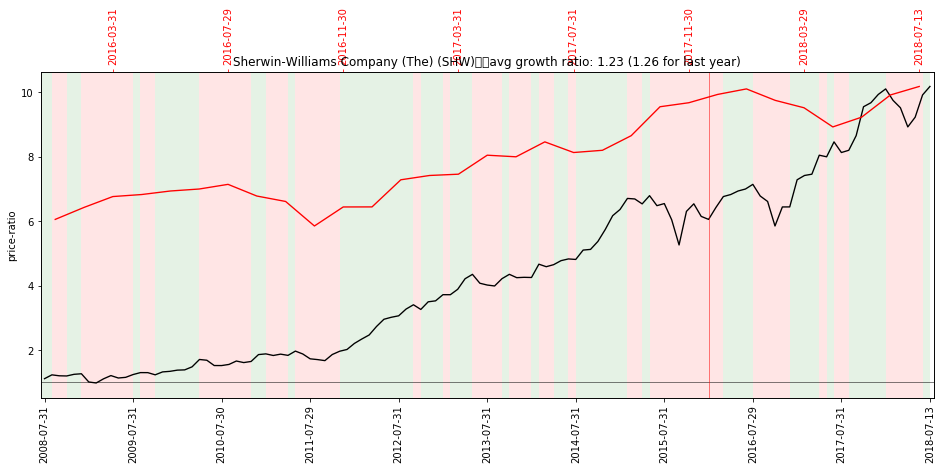

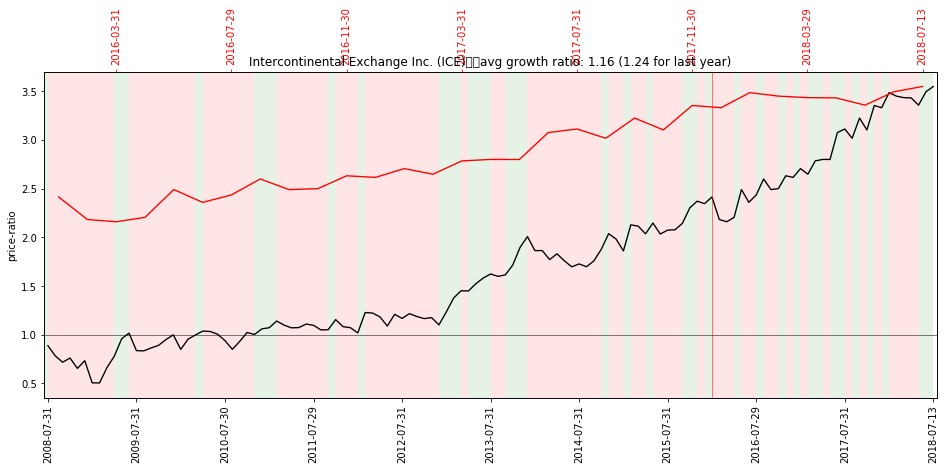

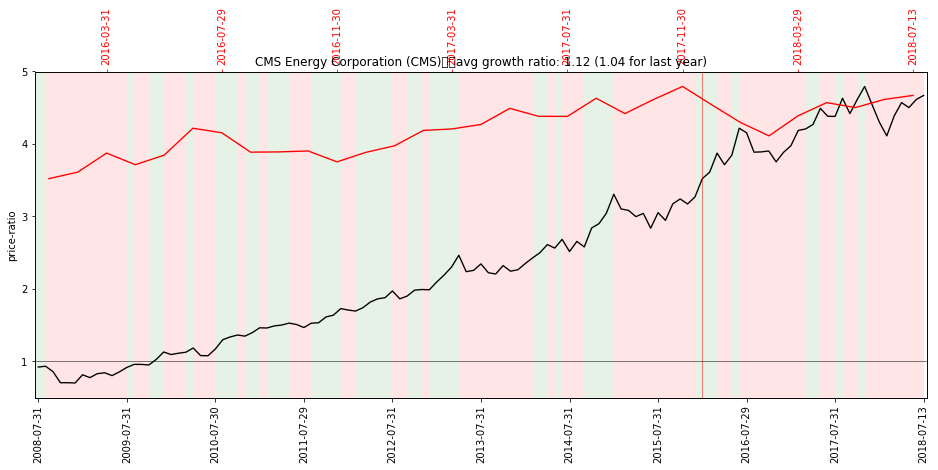

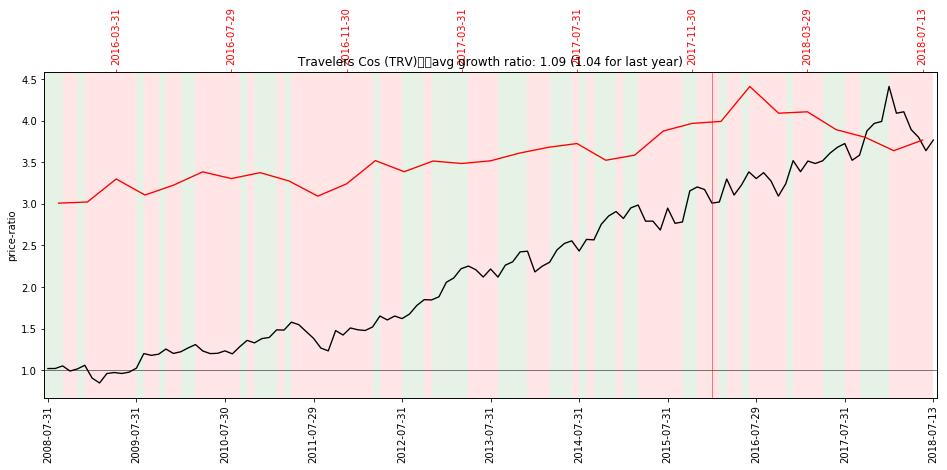

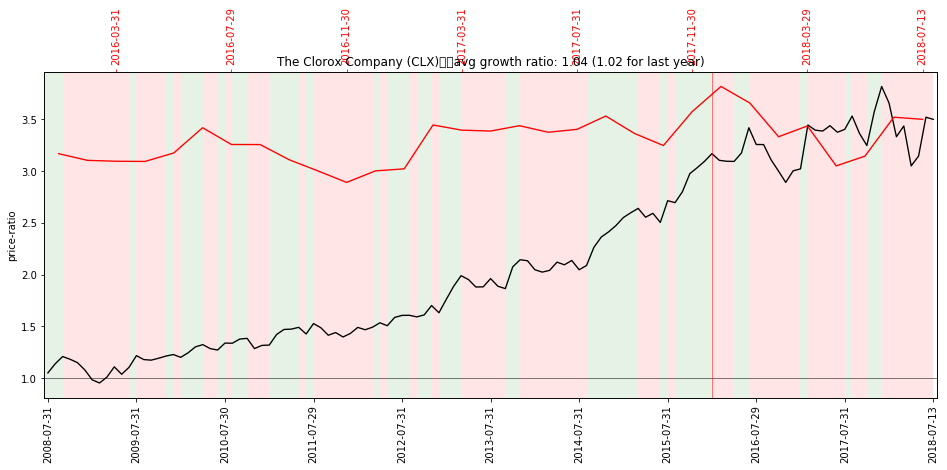

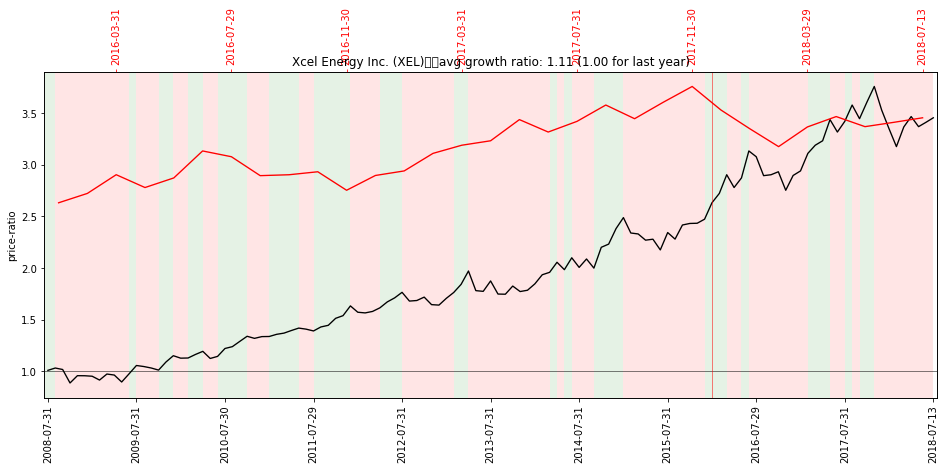

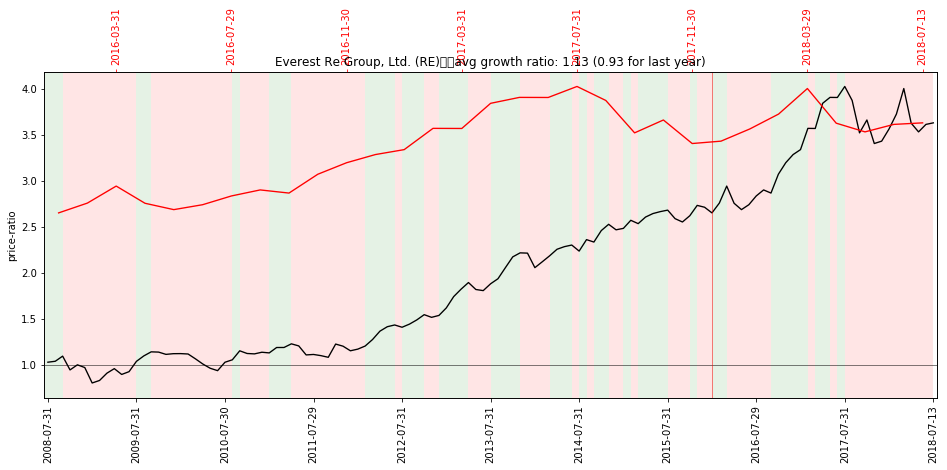

In [647]:
hp = hist_per['last-10y']
drop_period_lt_365 = dict(filter(lambda item: item[1]['drop-period'].max() < 365, hp.items()))
print('Found {} symbols'.format(len(drop_period_lt_365)))
draw_symbols_sorted_by_price_growth_1y(hist_per['last-10y'], drop_period_lt_365.keys())

## Look at symbols with max drop-period < 450 days for for different periods

In [648]:
for (period_name, x) in abs_periods:
    hp = hist_per[period_name]
    drop_period_lt_450 = dict(filter(lambda item: item[1]['drop-period'].max() < 450, hp.items()))
    print('For period "{}" found {} symbols'.format(period_name, len(drop_period_lt_450)))

For period "last-15y" found 1 symbols
For period "last-10y" found 24 symbols
For period "last-7y" found 129 symbols
For period "last-5y" found 163 symbols
For period "last-3y" found 271 symbols
For period "last-2y" found 384 symbols


## Look at symbols with max drop-period < 450 days for last 10 years sorted by price-ratio growth in last year

Found 24 symbols


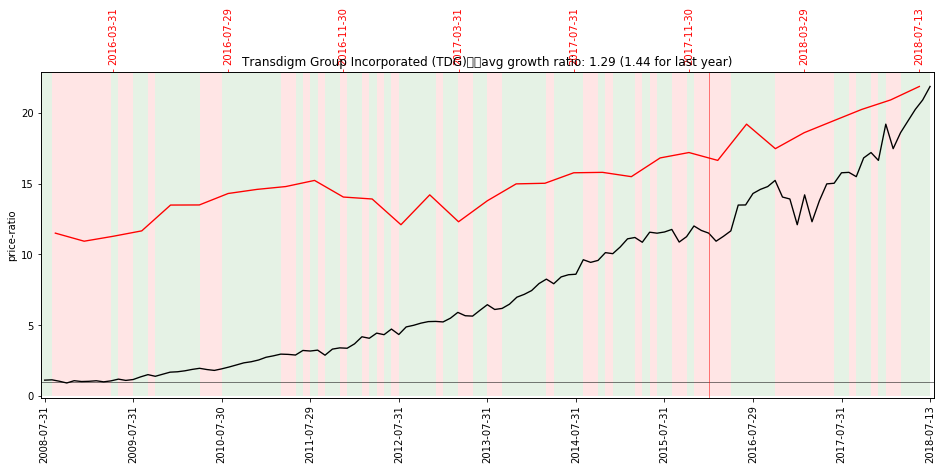

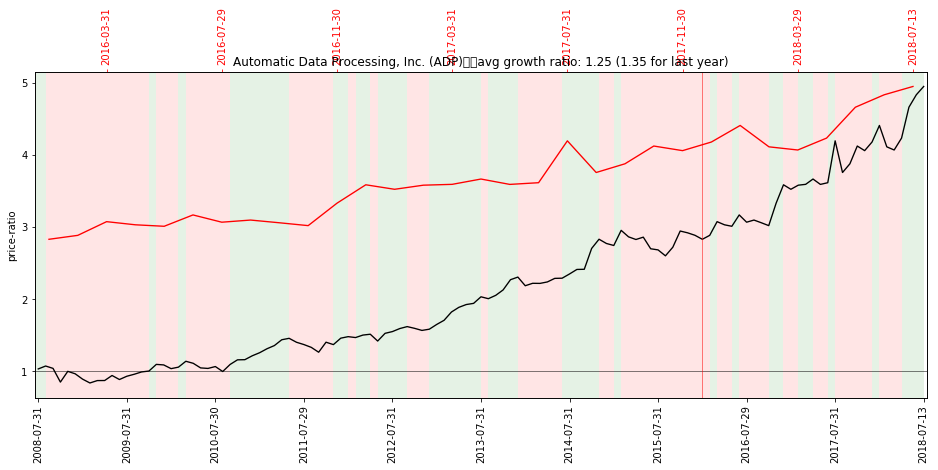

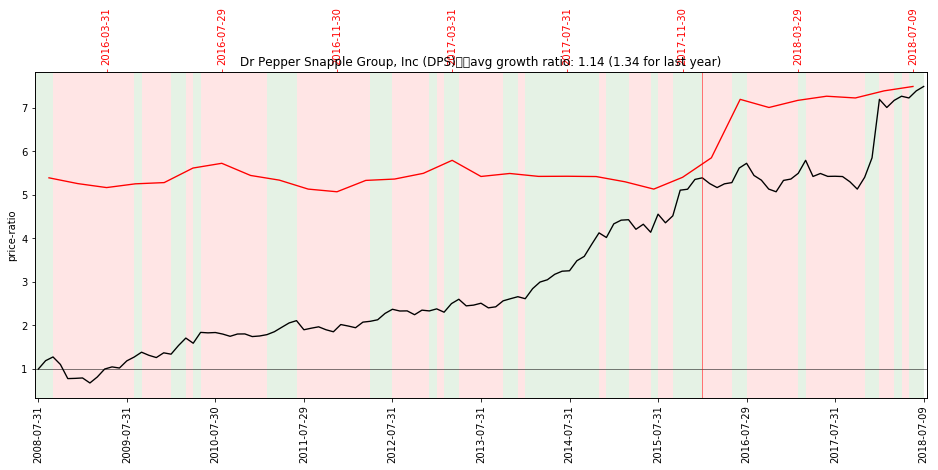

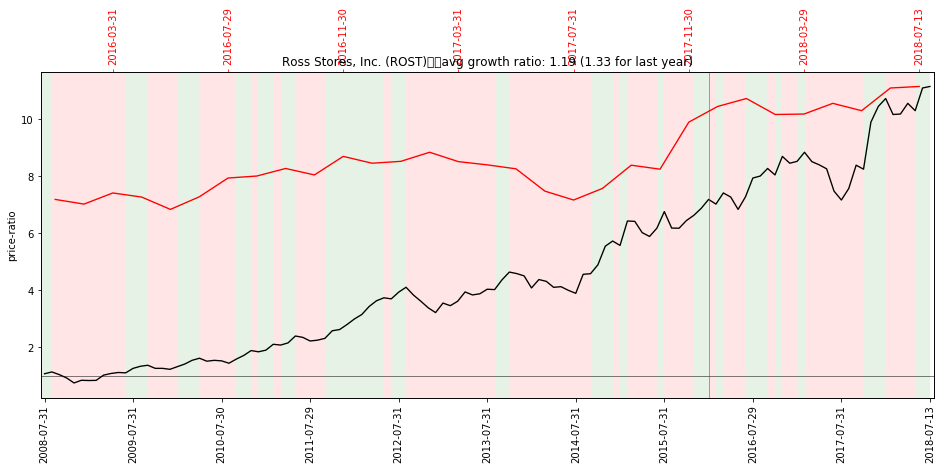

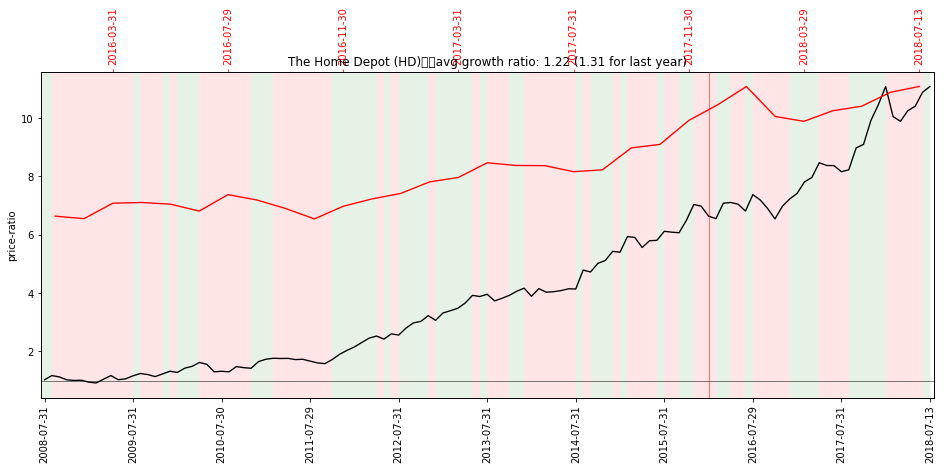

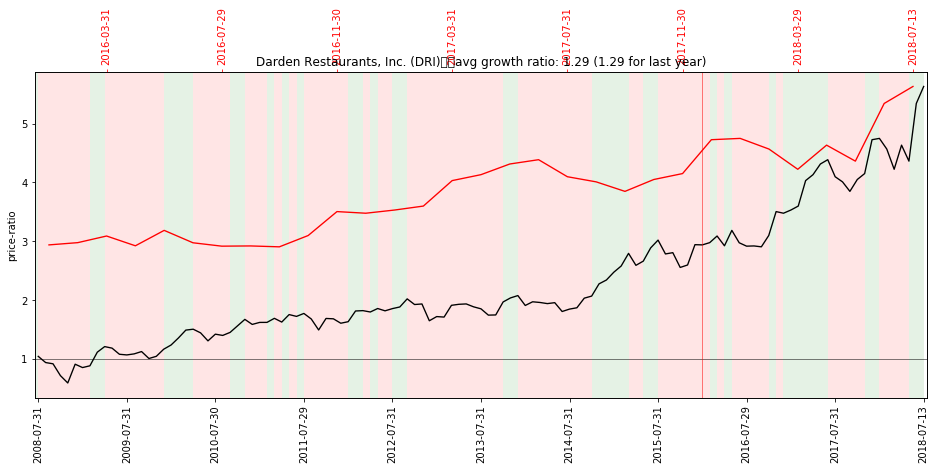

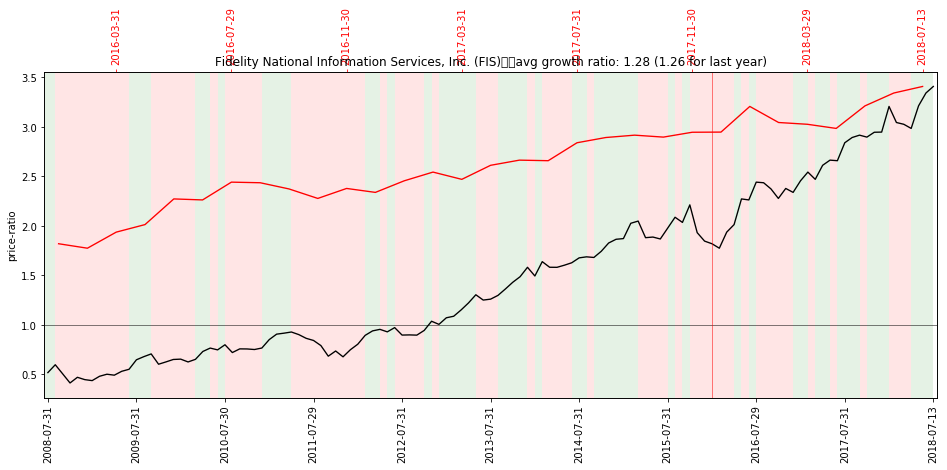

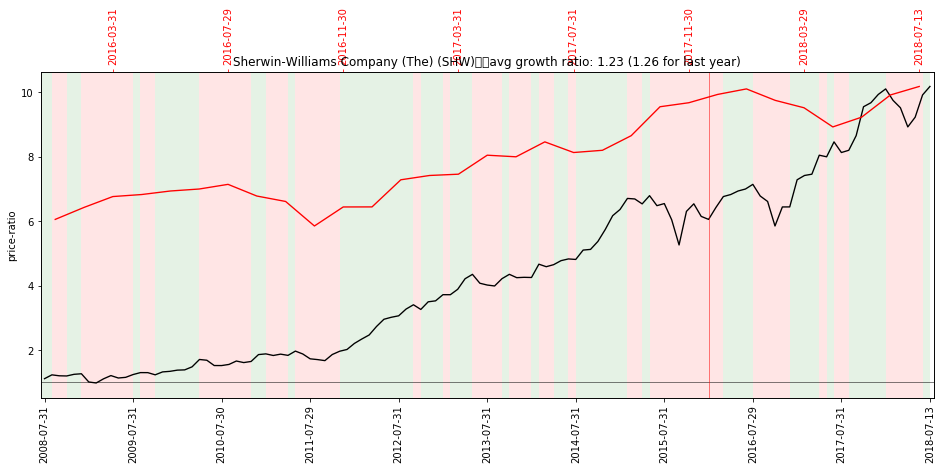

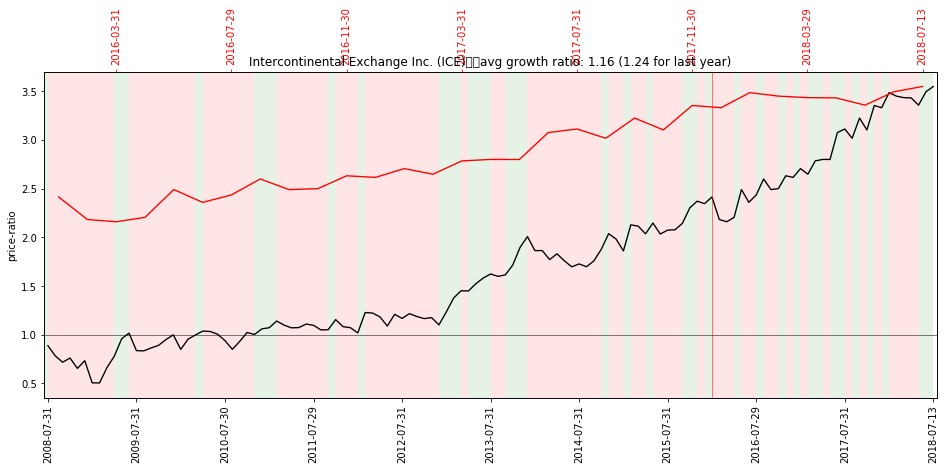

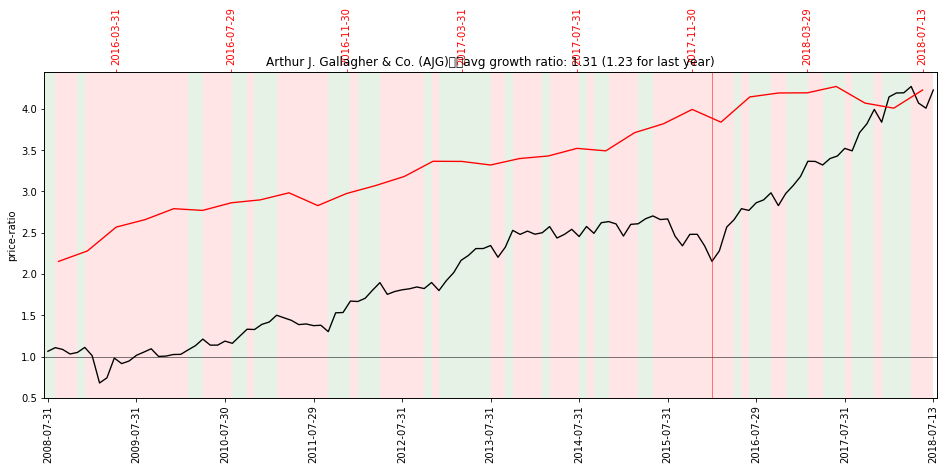

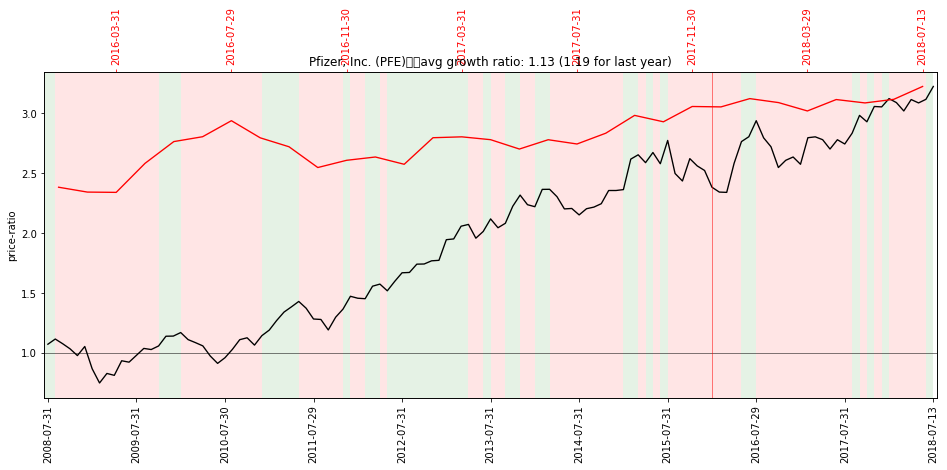

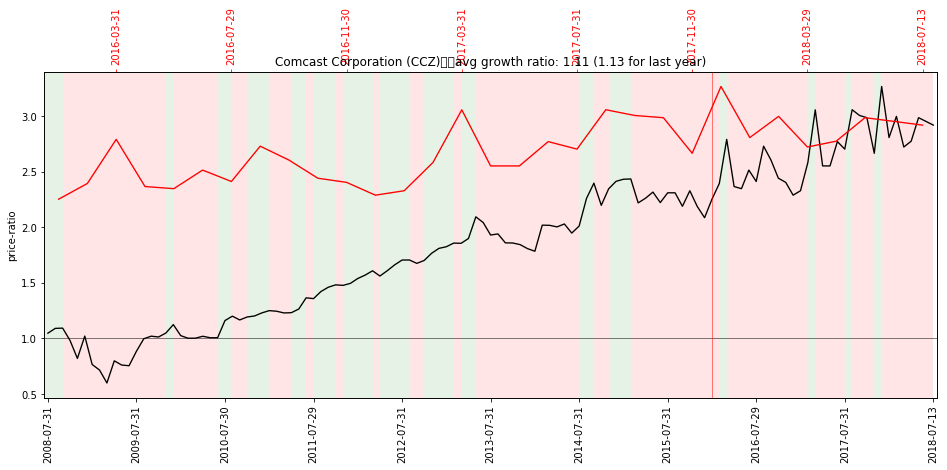

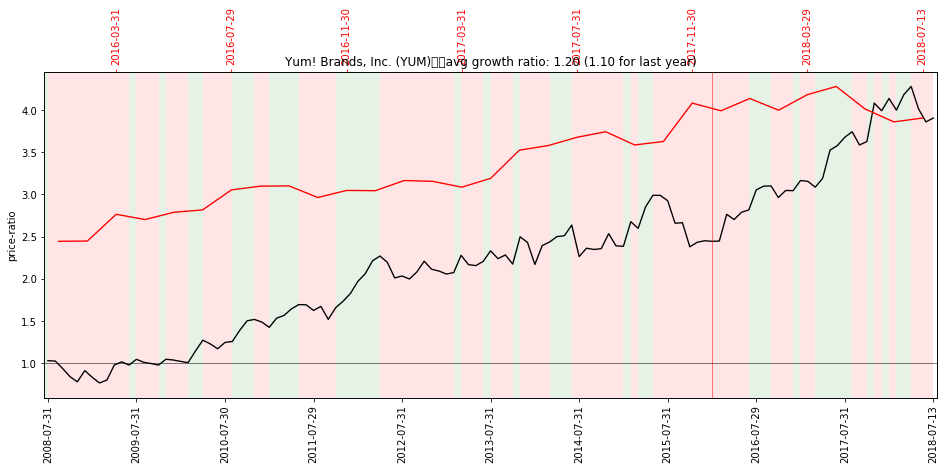

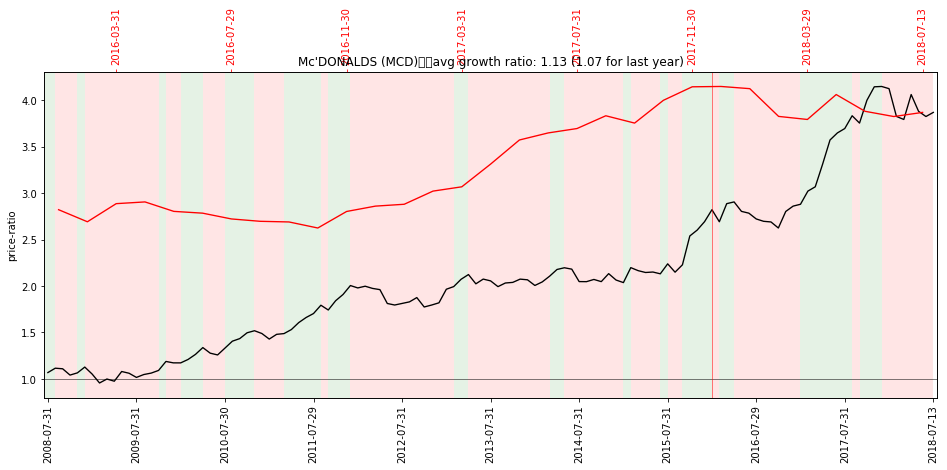

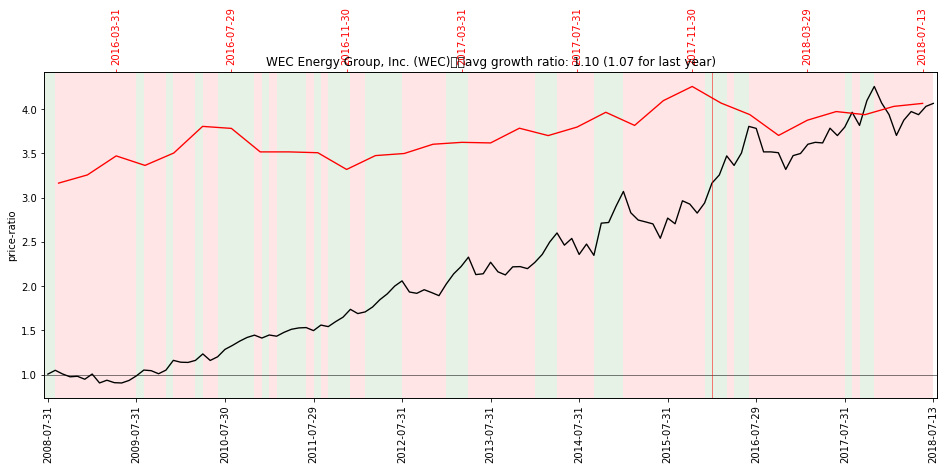

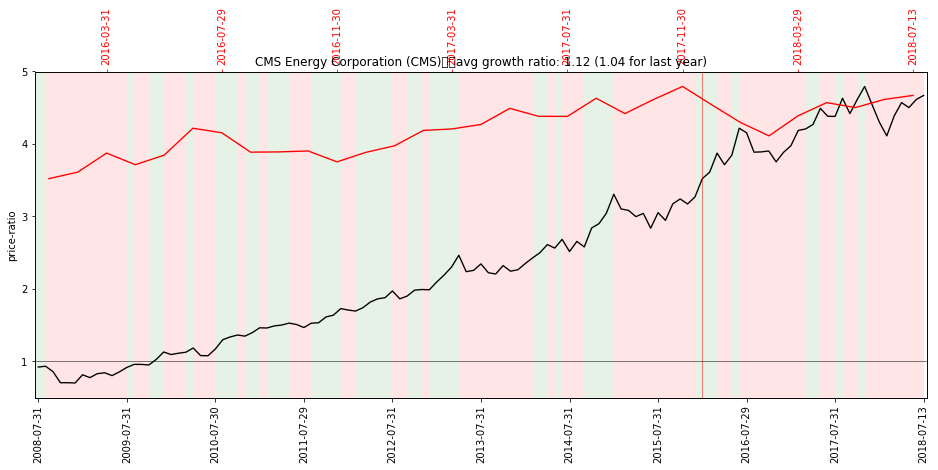

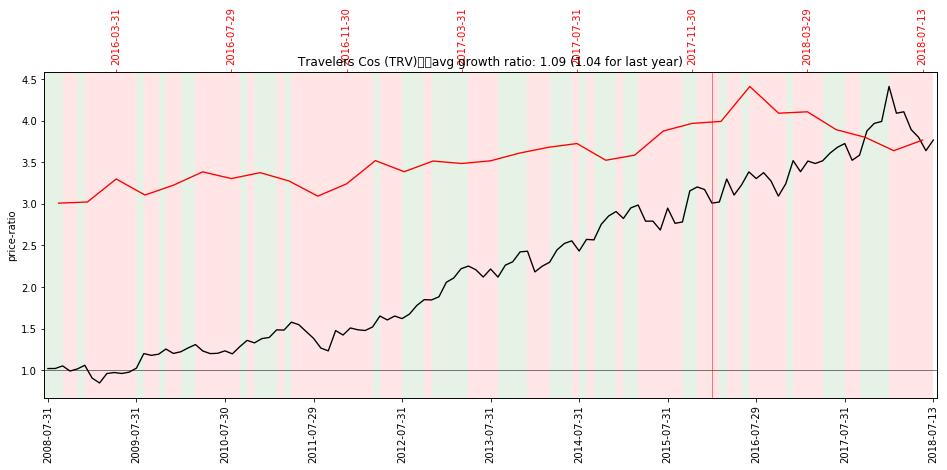

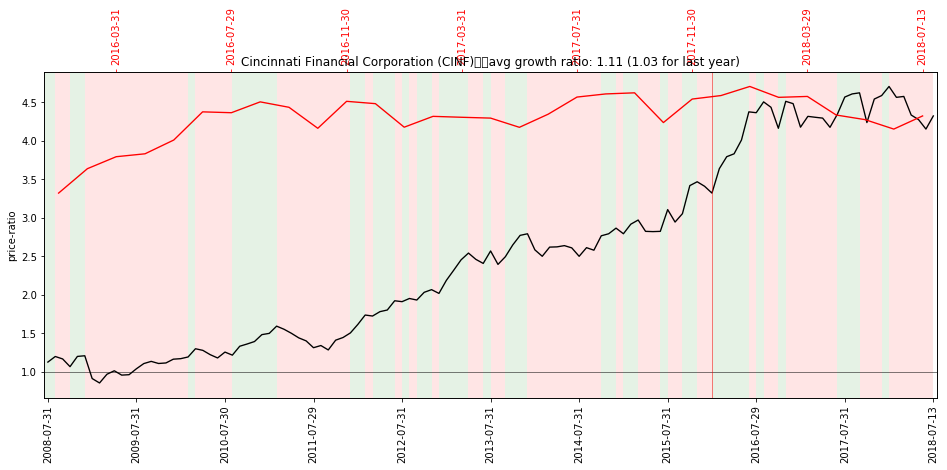

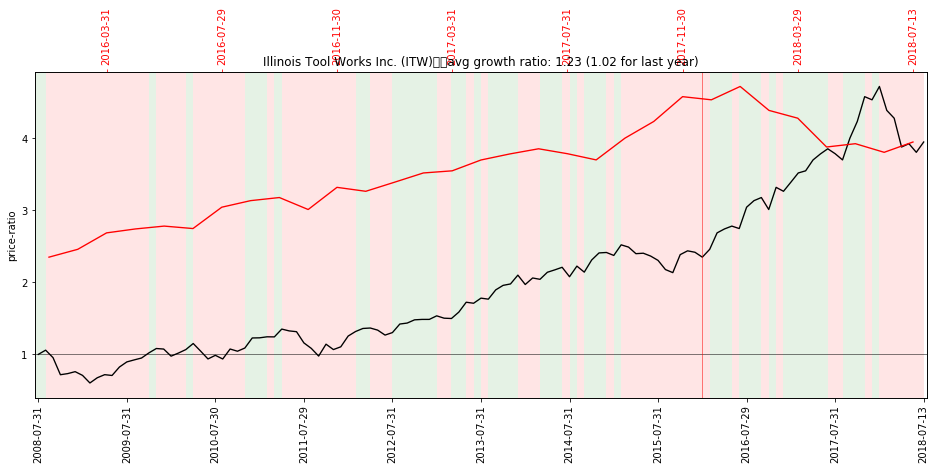

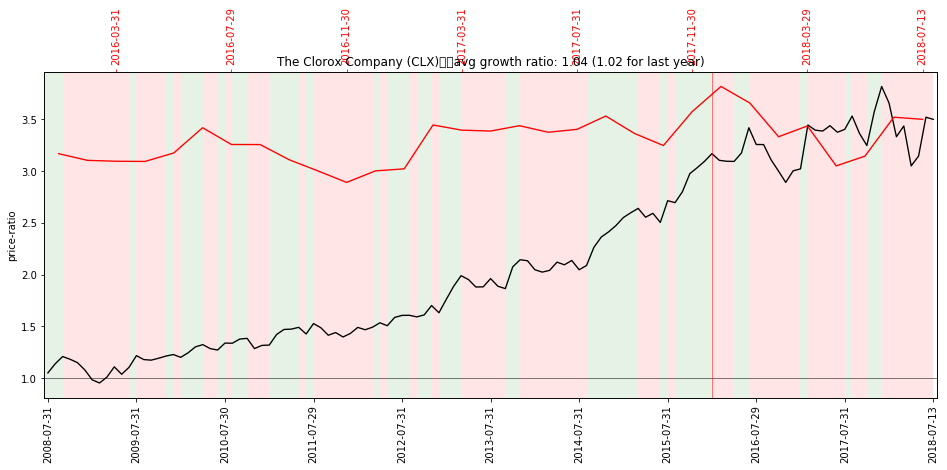

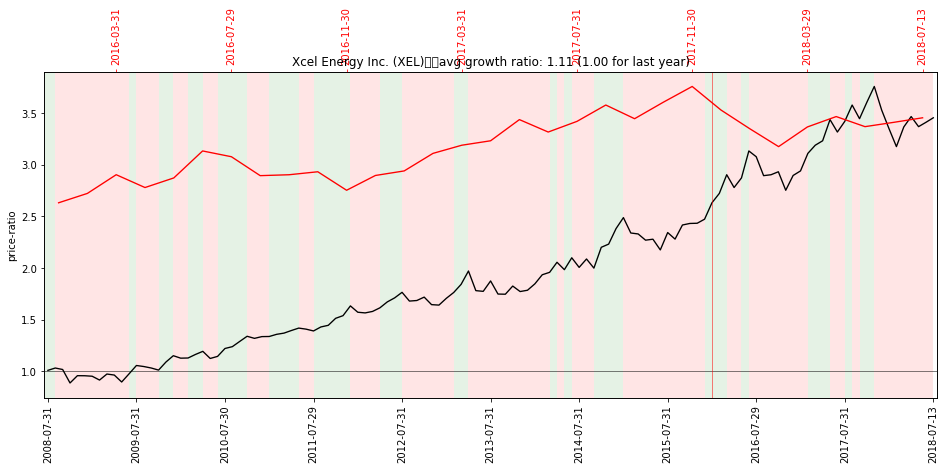

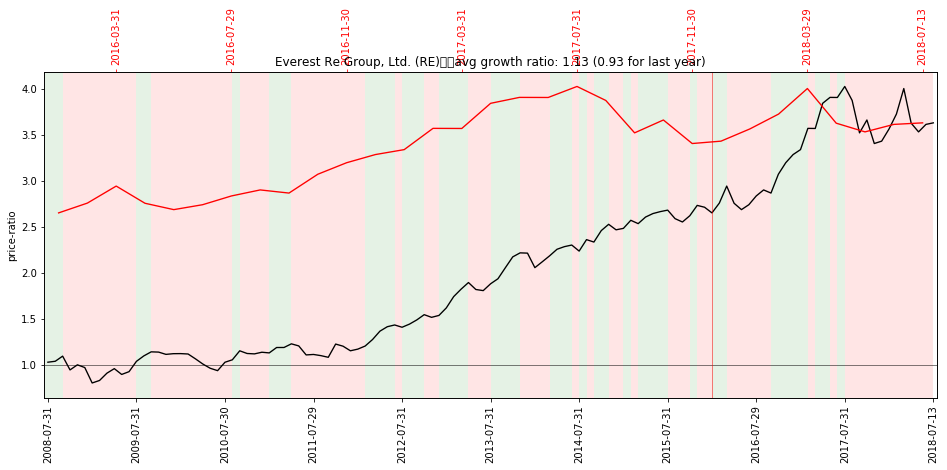

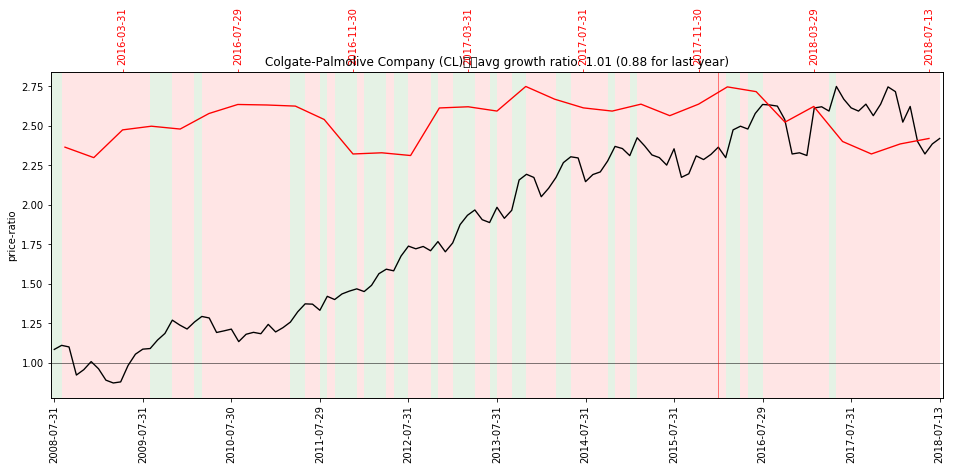

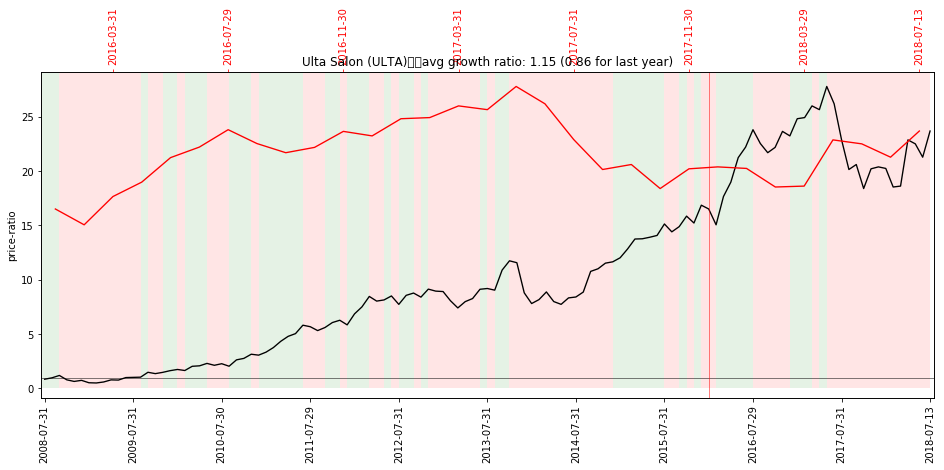

In [649]:
hp = hist_per['last-10y']
drop_period_lt_450 = dict(filter(lambda item: item[1]['drop-period'].max() < 450, hp.items()))
print('Found {} symbols'.format(len(drop_period_lt_450)))
draw_symbols_sorted_by_price_growth_1y(hist_per['last-10y'], drop_period_lt_450.keys())

## Look at symbols with min peice-drop < 0.2

Found 13 symbols


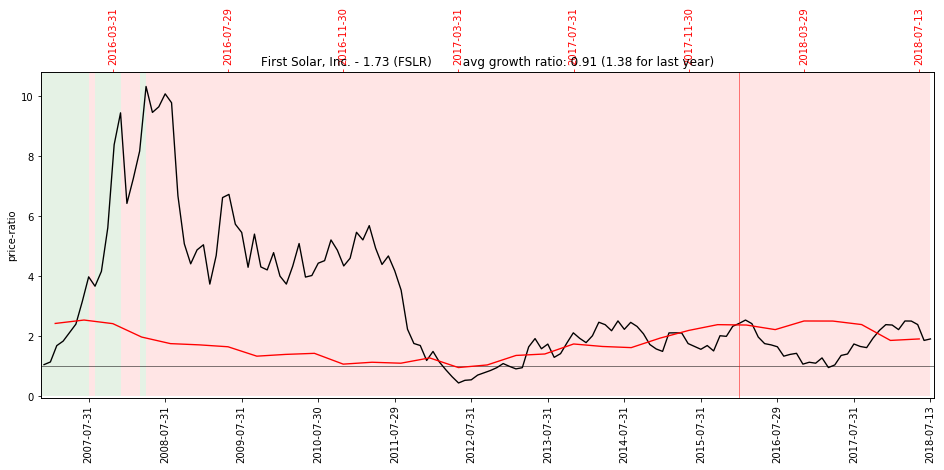

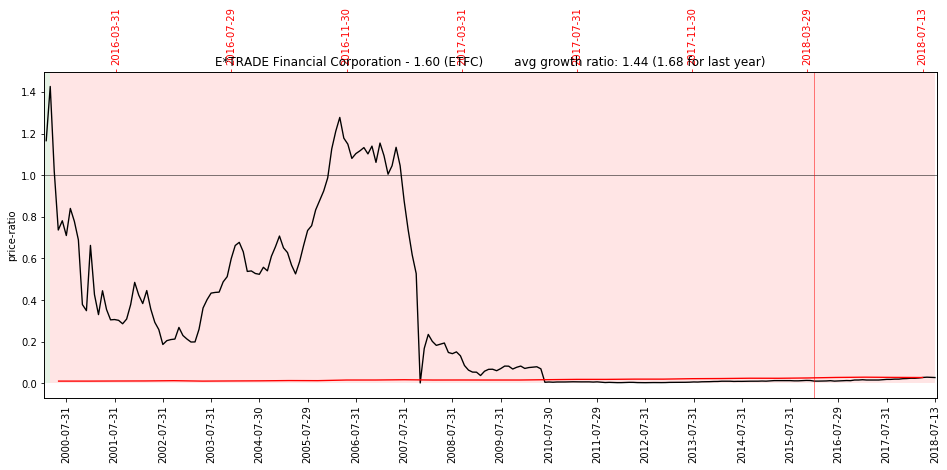

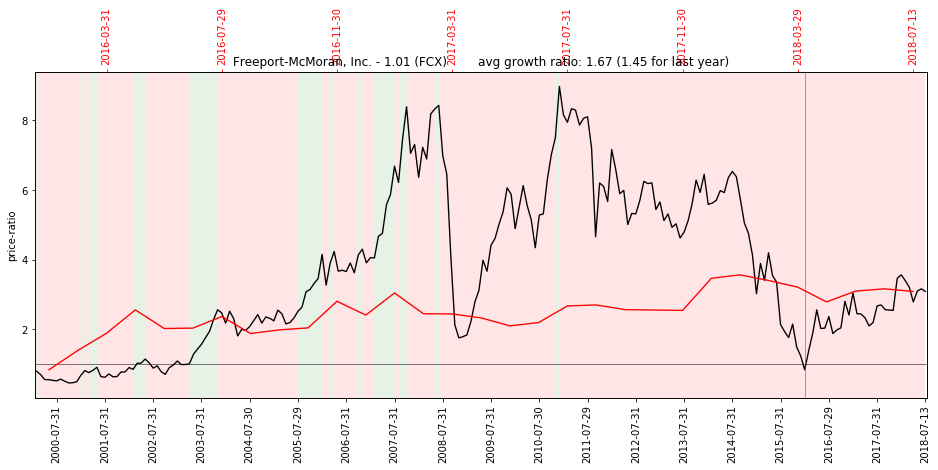

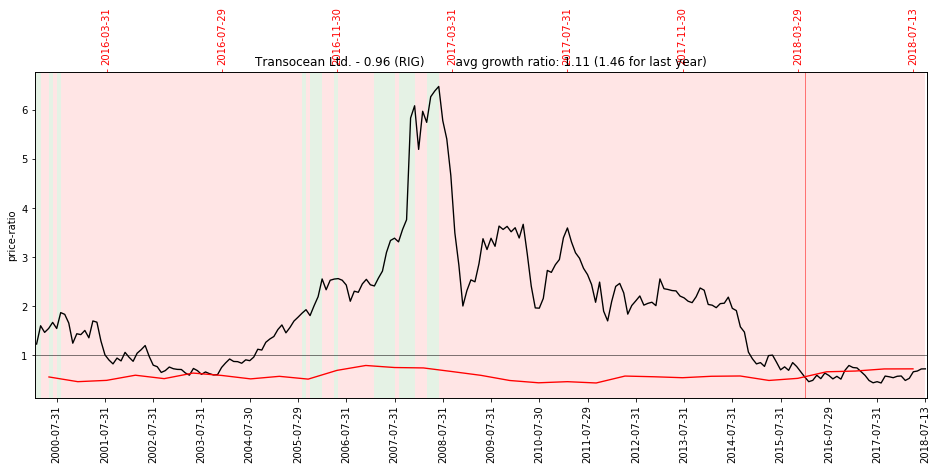

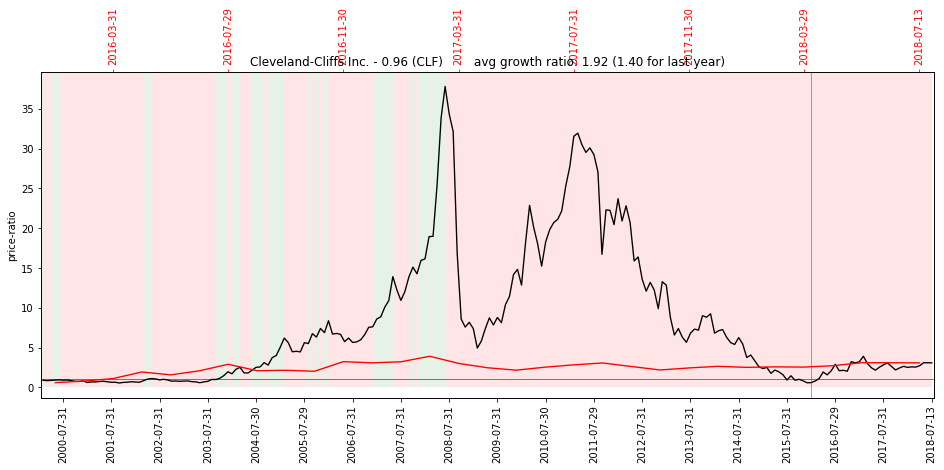

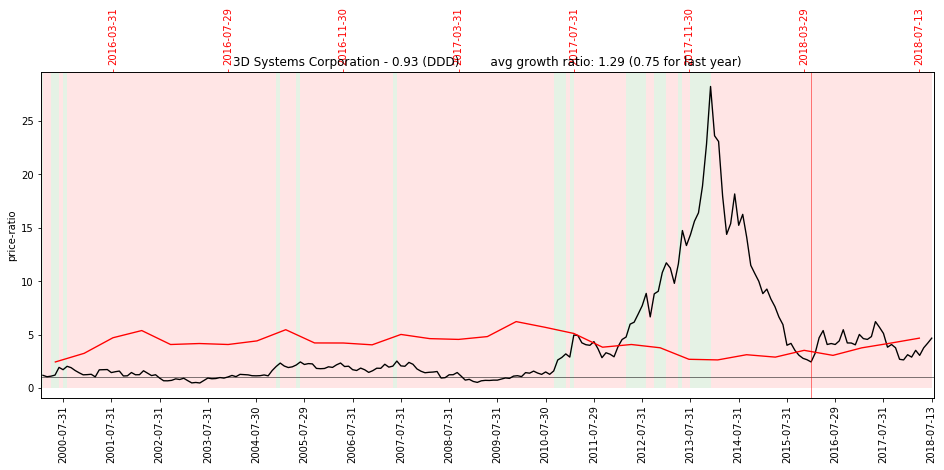

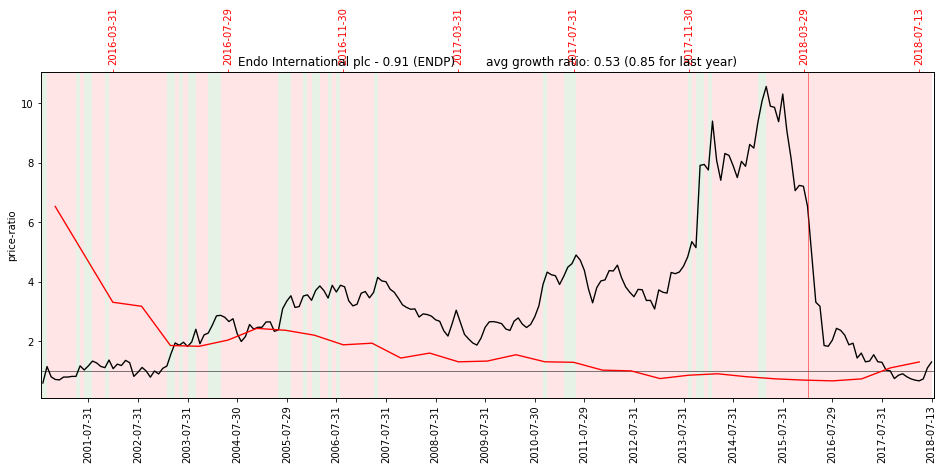

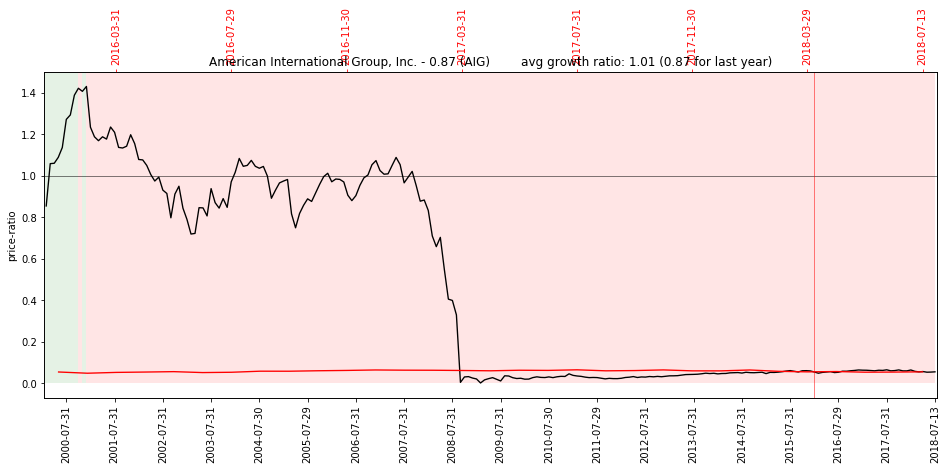

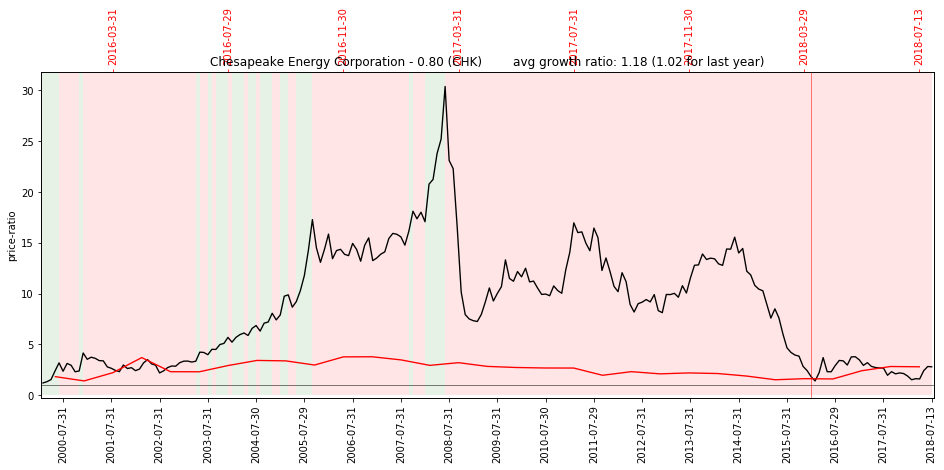

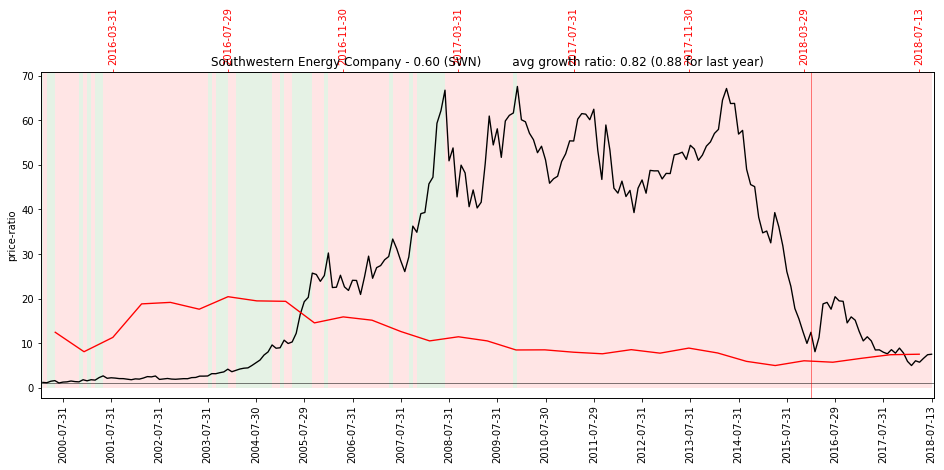

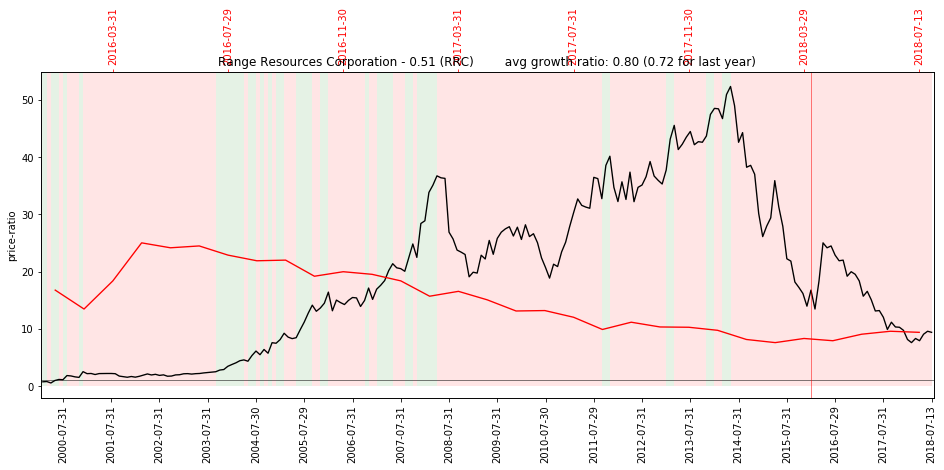

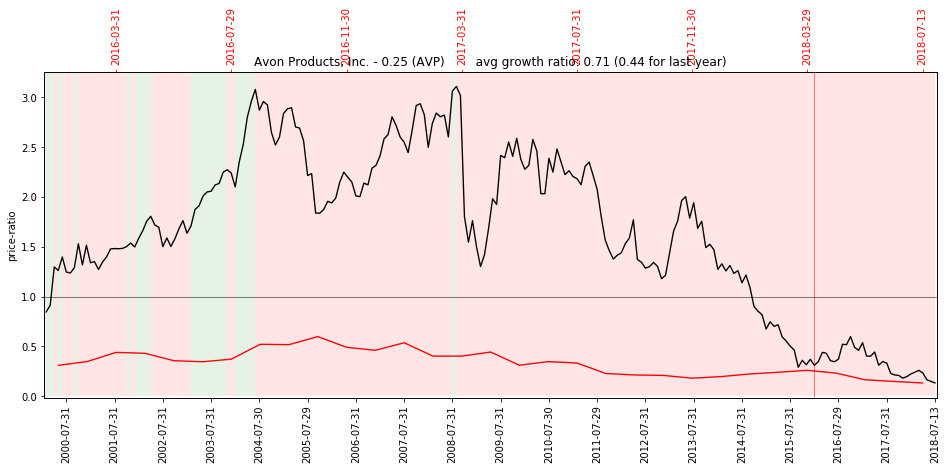

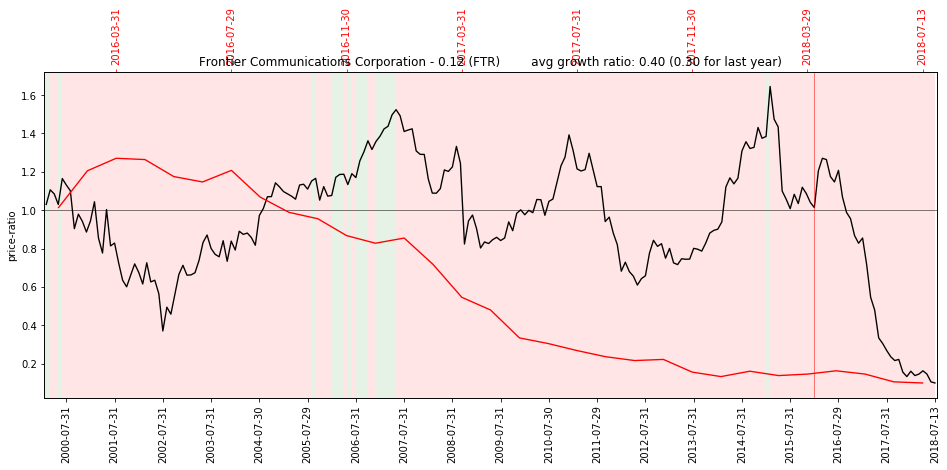

In [650]:
# hp = hist_per['last-50']
price_dorps_lt_02 = dict(filter(lambda item: item[1]['price-drop'].iloc[-len(item[1])//4:].min() < 0.2, hp.items()))
price_dorps_lt_02 = sorted([(hist_per['all'][symbol]['price-ratio'].loc['2017':][-1] / hist_per['all'][symbol]['price-ratio'].loc['2017':][0], symbol) for (symbol, h) in price_dorps_lt_02.items()], reverse = True)
print('Found {} symbols'.format(len(price_dorps_lt_02)))
for (ratio, symbol) in  price_dorps_lt_02:
    draw_price_ratio(hist_per['all'], symbol, '%s - %.2f'%(stocks['Name'][symbol], ratio), period = ('2016', '2100'))